#### Loading the necessary libraries and packages

In [1]:
# Load tensorflow
import tensorflow as tf
# Below command is to avoid the known bug which prevents computation on some GPU devices
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# Load preprocessing tools
from tensorflow.keras.utils import Sequence
from scipy.ndimage.filters import gaussian_filter
from PIL import Image
# Load model building blocks
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
# Load pre-trained model library
from tensorflow.keras import applications
# Load miscelaneous libraries
import numpy as np
import os
import matplotlib.pylab as plt
import gc

#### Define paths

In [2]:
train_image_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'image_data', 'small', '4000', 'train')
val_image_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'image_data', 'small', '4000', 'val')
train_labels_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'labels', 'small', '4000', 'train')
val_labels_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'labels', 'small', '4000', 'val')
load_models_path = os.path.join('/home', 'renat_sergazinov', 'python-git-workspace', 
                               'PhotoForceReconML', 'models')
save_models_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'models', 'small', '4000')

#### Data preprocessing and augmentation

Sort the labels according to the inner (contact) angle.

In [4]:
# Load the train and validation sets

X_train, X_val = {}, {}
y_train, y_val = {}, {}

for k in range(5):
    i = k + 2
    X_path_train = os.path.join(train_image_path, str(i))
    X_path_val = os.path.join(val_image_path, str(i))
    X_train[i] = [os.path.join(X_path_train, name) for name in sorted(os.listdir(X_path_train), key = sorter)]
    X_val[i] = [os.path.join(X_path_val, name) for name in sorted(os.listdir(X_path_val), key = sorter)]
    y_train[i] = np.load(os.path.join(train_labels_path, str(i), 'angles_tang.npy'))
    y_val[i] = np.load(os.path.join(val_labels_path, str(i), 'angles_tang.npy'))

Data generators are created and defind here. Images are blurred using Gaussian blur with kernel radius = 1.The pixel values are scaled using 1/255 to be in the interval [0,1]. The images are further rescaled to 128*128 with Nearest interpolation. 

In [7]:
# Apply data generators
gaussblur = GaussBlur(1)
params = {'batch_size': 32, 
          'dim': (128, 128), 
          'n_channels': 3, 
          'rescale': 1 / 255, 
          'shuffle': True, 
          'save_dir': None,
          'preprocessing_func': gaussblur.blur
          }

training_generator = {}
validation_generator = {}

for k in range(5):
    i = k + 2
    training_generator[i] = DataGeneratorTrain(X_train[i], y_train[i], **params)
    validation_generator[i] = DataGeneratorTrain(X_val[i], y_val[i], **params)

#### XCEPTION Training

In [8]:
# Load models
models_at = dict()                         
for k in range(5):
     i = k + 2
     models_at[i] = load_model(os.path.join(load_models_path, 'xception_angles_tang_'+str(i)+'.h5'))

In [9]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = dict()
for k in range(5):
    i = k + 2
    model_path = os.path.join(save_models_path, 'xception_angles_tang_'+str(i)+'.h5')
    mc[i] = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [10]:
for k in range(5):
    i = k + 2
    models_at[i].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 22,961,706
Trainable params: 22,907,178
Non-trainable params: 54,528
____________________________________________

In [11]:
for k in range(5):
    i = 2 + k
    models_at[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=0.1),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

In [12]:
epochs = 1000
history_ft = {}

for k in range(5):
    i = k + 2
    print('Model for ', i, ' angles')
    history_ft[i] = models_at[i].fit(training_generator[i],
                            validation_data = validation_generator[i],
                            epochs = epochs,
                            steps_per_epoch = len(training_generator[i]),
                            validation_steps = len(validation_generator[i]),
                            callbacks=[es, mc[i]]
                           )

Model for  2  angles
Epoch 1/1000
100/100 [==============================] - ETA: 0s - loss: 0.0953 - mean_absolute_error: 0.0953
Epoch 00001: val_loss improved from inf to 0.07630, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 14s 145ms/step - loss: 0.0953 - mean_absolute_error: 0.0953 - val_loss: 0.0763 - val_mean_absolute_error: 0.0763
Epoch 2/1000
100/100 [==============================] - ETA: 0s - loss: 0.0914 - mean_absolute_error: 0.0914
Epoch 00002: val_loss improved from 0.07630 to 0.07254, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 14s 137ms/step - loss: 0.0914 - mean_absolute_error: 0.0914 - val_loss: 0.0725 - val_mean_absolute_error: 0.0725
Epoch 3/1000
100/100 [==============================] - ETA: 0s - loss: 0.0875 - mean_absolute_er

100/100 [==============================] - 14s 138ms/step - loss: 0.0651 - mean_absolute_error: 0.0651 - val_loss: 0.0505 - val_mean_absolute_error: 0.0505
Epoch 20/1000
100/100 [==============================] - ETA: 0s - loss: 0.0644 - mean_absolute_error: 0.0644
Epoch 00020: val_loss improved from 0.05047 to 0.04989, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.0644 - mean_absolute_error: 0.0644 - val_loss: 0.0499 - val_mean_absolute_error: 0.0499
Epoch 21/1000
100/100 [==============================] - ETA: 0s - loss: 0.0646 - mean_absolute_error: 0.0646
Epoch 00021: val_loss improved from 0.04989 to 0.04980, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 133ms/step - loss: 0.0646 - mean_absolute_error: 0.0646 - val_los

100/100 [==============================] - 13s 130ms/step - loss: 0.0520 - mean_absolute_error: 0.0520 - val_loss: 0.0432 - val_mean_absolute_error: 0.0432
Epoch 58/1000
100/100 [==============================] - ETA: 0s - loss: 0.0512 - mean_absolute_error: 0.0512
Epoch 00058: val_loss improved from 0.04319 to 0.04289, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.0512 - mean_absolute_error: 0.0512 - val_loss: 0.0429 - val_mean_absolute_error: 0.0429
Epoch 59/1000
100/100 [==============================] - ETA: 0s - loss: 0.0516 - mean_absolute_error: 0.0516
Epoch 00059: val_loss improved from 0.04289 to 0.04285, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 132ms/step - loss: 0.0516 - mean_absolute_error: 0.0516 - val_los

100/100 [==============================] - 13s 130ms/step - loss: 0.0483 - mean_absolute_error: 0.0483 - val_loss: 0.0414 - val_mean_absolute_error: 0.0414
Epoch 79/1000
100/100 [==============================] - ETA: 0s - loss: 0.0472 - mean_absolute_error: 0.0472
Epoch 00079: val_loss did not improve from 0.04137
100/100 [==============================] - 13s 126ms/step - loss: 0.0472 - mean_absolute_error: 0.0472 - val_loss: 0.0414 - val_mean_absolute_error: 0.0414
Epoch 80/1000
100/100 [==============================] - ETA: 0s - loss: 0.0484 - mean_absolute_error: 0.0484
Epoch 00080: val_loss improved from 0.04137 to 0.04121, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.0484 - mean_absolute_error: 0.0484 - val_loss: 0.0412 - val_mean_absolute_error: 0.0412
Epoch 81/1000
100/100 [==============================] - ETA: 0s - loss: 0.0476 - m

Epoch 122/1000
100/100 [==============================] - ETA: 0s - loss: 0.0438 - mean_absolute_error: 0.0438
Epoch 00122: val_loss improved from 0.03945 to 0.03942, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.0438 - mean_absolute_error: 0.0438 - val_loss: 0.0394 - val_mean_absolute_error: 0.0394
Epoch 123/1000
100/100 [==============================] - ETA: 0s - loss: 0.0438 - mean_absolute_error: 0.0438
Epoch 00123: val_loss did not improve from 0.03942
100/100 [==============================] - 12s 125ms/step - loss: 0.0438 - mean_absolute_error: 0.0438 - val_loss: 0.0396 - val_mean_absolute_error: 0.0396
Epoch 124/1000
100/100 [==============================] - ETA: 0s - loss: 0.0440 - mean_absolute_error: 0.0440
Epoch 00124: val_loss improved from 0.03942 to 0.03920, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForce

Epoch 144/1000
100/100 [==============================] - ETA: 0s - loss: 0.0423 - mean_absolute_error: 0.0423
Epoch 00144: val_loss improved from 0.03860 to 0.03855, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.0423 - mean_absolute_error: 0.0423 - val_loss: 0.0385 - val_mean_absolute_error: 0.0385
Epoch 145/1000
100/100 [==============================] - ETA: 0s - loss: 0.0415 - mean_absolute_error: 0.0415
Epoch 00145: val_loss did not improve from 0.03855
100/100 [==============================] - 12s 124ms/step - loss: 0.0415 - mean_absolute_error: 0.0415 - val_loss: 0.0387 - val_mean_absolute_error: 0.0387
Epoch 146/1000
100/100 [==============================] - ETA: 0s - loss: 0.0420 - mean_absolute_error: 0.0420
Epoch 00146: val_loss did not improve from 0.03855
100/100 [==============================] - 13s 125ms/step - loss: 0.0420 - 

100/100 [==============================] - ETA: 0s - loss: 0.0397 - mean_absolute_error: 0.0397
Epoch 00190: val_loss did not improve from 0.03742
100/100 [==============================] - 13s 125ms/step - loss: 0.0397 - mean_absolute_error: 0.0397 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375
Epoch 191/1000
100/100 [==============================] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.0391
Epoch 00191: val_loss did not improve from 0.03742
100/100 [==============================] - 12s 124ms/step - loss: 0.0391 - mean_absolute_error: 0.0391 - val_loss: 0.0374 - val_mean_absolute_error: 0.0374
Epoch 192/1000
100/100 [==============================] - ETA: 0s - loss: 0.0398 - mean_absolute_error: 0.0398
Epoch 00192: val_loss did not improve from 0.03742
100/100 [==============================] - 12s 125ms/step - loss: 0.0398 - mean_absolute_error: 0.0398 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375
Epoch 193/1000
100/100 [==============================] - ETA

Epoch 214/1000
100/100 [==============================] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378
Epoch 00214: val_loss did not improve from 0.03710
100/100 [==============================] - 12s 124ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - val_loss: 0.0372 - val_mean_absolute_error: 0.0372
Epoch 215/1000
100/100 [==============================] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.0392
Epoch 00215: val_loss improved from 0.03710 to 0.03700, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.0392 - mean_absolute_error: 0.0392 - val_loss: 0.0370 - val_mean_absolute_error: 0.0370
Epoch 216/1000
100/100 [==============================] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377
Epoch 00216: val_loss did not improve from 0.03700
100/100 [==============================] - 12s 124ms/step - loss: 0.0377 - 

Epoch 238/1000
100/100 [==============================] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367
Epoch 00238: val_loss did not improve from 0.03659
100/100 [==============================] - 12s 125ms/step - loss: 0.0367 - mean_absolute_error: 0.0367 - val_loss: 0.0368 - val_mean_absolute_error: 0.0368
Epoch 239/1000
100/100 [==============================] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377
Epoch 00239: val_loss did not improve from 0.03659
100/100 [==============================] - 13s 125ms/step - loss: 0.0377 - mean_absolute_error: 0.0377 - val_loss: 0.0366 - val_mean_absolute_error: 0.0366
Epoch 240/1000
100/100 [==============================] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370
Epoch 00240: val_loss improved from 0.03659 to 0.03657, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 128ms/step - loss: 0.0370 - 

Epoch 262/1000
100/100 [==============================] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359
Epoch 00262: val_loss improved from 0.03629 to 0.03627, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0363 - val_mean_absolute_error: 0.0363
Epoch 263/1000
100/100 [==============================] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362
Epoch 00263: val_loss improved from 0.03627 to 0.03616, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.0362 - mean_absolute_error: 0.0362 - val_loss: 0.0362 - val_mean_absolute_error: 0.0362
Epoch 264/1000
100/100 [==============================] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

Epoch 286/1000
100/100 [==============================] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359
Epoch 00286: val_loss did not improve from 0.03603
100/100 [==============================] - 12s 123ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0363 - val_mean_absolute_error: 0.0363
Epoch 287/1000
100/100 [==============================] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357
Epoch 00287: val_loss did not improve from 0.03603
100/100 [==============================] - 13s 126ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0363 - val_mean_absolute_error: 0.0363
Epoch 288/1000
100/100 [==============================] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355
Epoch 00288: val_loss improved from 0.03603 to 0.03598, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.0355 - 

Epoch 311/1000
100/100 [==============================] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350
Epoch 00311: val_loss did not improve from 0.03577
100/100 [==============================] - 12s 123ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0358 - val_mean_absolute_error: 0.0358
Epoch 312/1000
100/100 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354
Epoch 00312: val_loss did not improve from 0.03577
100/100 [==============================] - 12s 124ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0359 - val_mean_absolute_error: 0.0359
Epoch 313/1000
100/100 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342
Epoch 00313: val_loss improved from 0.03577 to 0.03564, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.0342 - 

100/100 [==============================] - 13s 131ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0354 - val_mean_absolute_error: 0.0354
Epoch 335/1000
100/100 [==============================] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345
Epoch 00335: val_loss did not improve from 0.03539
100/100 [==============================] - 12s 123ms/step - loss: 0.0345 - mean_absolute_error: 0.0345 - val_loss: 0.0354 - val_mean_absolute_error: 0.0354
Epoch 336/1000
100/100 [==============================] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345
Epoch 00336: val_loss improved from 0.03539 to 0.03538, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.0345 - mean_absolute_error: 0.0345 - val_loss: 0.0354 - val_mean_absolute_error: 0.0354
Epoch 337/1000
100/100 [==============================] - ETA: 0s - loss: 0.0345 

Epoch 384/1000
100/100 [==============================] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.0335
Epoch 00384: val_loss did not improve from 0.03488
100/100 [==============================] - 12s 125ms/step - loss: 0.0335 - mean_absolute_error: 0.0335 - val_loss: 0.0351 - val_mean_absolute_error: 0.0351
Epoch 385/1000
100/100 [==============================] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338
Epoch 00385: val_loss did not improve from 0.03488
100/100 [==============================] - 12s 125ms/step - loss: 0.0338 - mean_absolute_error: 0.0338 - val_loss: 0.0353 - val_mean_absolute_error: 0.0353
Epoch 386/1000
100/100 [==============================] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334
Epoch 00386: val_loss did not improve from 0.03488
100/100 [==============================] - 12s 124ms/step - loss: 0.0334 - mean_absolute_error: 0.0334 - val_loss: 0.0354 - val_mean_absolute_error: 0.0354
Epoch 387/1000
100/100 [======================

Epoch 409/1000
100/100 [==============================] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.0328
Epoch 00409: val_loss improved from 0.03475 to 0.03468, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.0328 - mean_absolute_error: 0.0328 - val_loss: 0.0347 - val_mean_absolute_error: 0.0347
Epoch 410/1000
100/100 [==============================] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329
Epoch 00410: val_loss did not improve from 0.03468
100/100 [==============================] - 13s 126ms/step - loss: 0.0329 - mean_absolute_error: 0.0329 - val_loss: 0.0348 - val_mean_absolute_error: 0.0348
Epoch 411/1000
100/100 [==============================] - ETA: 0s - loss: 0.0331 - mean_absolute_error: 0.0331
Epoch 00411: val_loss improved from 0.03468 to 0.03461, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForce

Epoch 432/1000
100/100 [==============================] - ETA: 0s - loss: 0.0318 - mean_absolute_error: 0.0318
Epoch 00432: val_loss improved from 0.03438 to 0.03437, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.0318 - mean_absolute_error: 0.0318 - val_loss: 0.0344 - val_mean_absolute_error: 0.0344
Epoch 433/1000
100/100 [==============================] - ETA: 0s - loss: 0.0322 - mean_absolute_error: 0.0322
Epoch 00433: val_loss did not improve from 0.03437
100/100 [==============================] - 12s 124ms/step - loss: 0.0322 - mean_absolute_error: 0.0322 - val_loss: 0.0346 - val_mean_absolute_error: 0.0346
Epoch 434/1000
100/100 [==============================] - ETA: 0s - loss: 0.0326 - mean_absolute_error: 0.0326
Epoch 00434: val_loss improved from 0.03437 to 0.03432, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForce

Epoch 455/1000
100/100 [==============================] - ETA: 0s - loss: 0.0322 - mean_absolute_error: 0.0322
Epoch 00455: val_loss did not improve from 0.03401
100/100 [==============================] - 12s 123ms/step - loss: 0.0322 - mean_absolute_error: 0.0322 - val_loss: 0.0340 - val_mean_absolute_error: 0.0340
Epoch 456/1000
100/100 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.0316
Epoch 00456: val_loss did not improve from 0.03401
100/100 [==============================] - 12s 125ms/step - loss: 0.0316 - mean_absolute_error: 0.0316 - val_loss: 0.0343 - val_mean_absolute_error: 0.0343
Epoch 457/1000
100/100 [==============================] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.0320
Epoch 00457: val_loss did not improve from 0.03401
100/100 [==============================] - 12s 125ms/step - loss: 0.0320 - mean_absolute_error: 0.0320 - val_loss: 0.0340 - val_mean_absolute_error: 0.0340
Epoch 458/1000
100/100 [======================

100/100 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.0316
Epoch 00504: val_loss did not improve from 0.03376
100/100 [==============================] - 13s 125ms/step - loss: 0.0316 - mean_absolute_error: 0.0316 - val_loss: 0.0339 - val_mean_absolute_error: 0.0339
Epoch 505/1000
100/100 [==============================] - ETA: 0s - loss: 0.0319 - mean_absolute_error: 0.0319
Epoch 00505: val_loss did not improve from 0.03376
100/100 [==============================] - 13s 128ms/step - loss: 0.0319 - mean_absolute_error: 0.0319 - val_loss: 0.0339 - val_mean_absolute_error: 0.0339
Epoch 506/1000
100/100 [==============================] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.0311
Epoch 00506: val_loss improved from 0.03376 to 0.03364, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 134ms/step - loss: 0.0311 - mean_absolute_e

100/100 [==============================] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.0311
Epoch 00529: val_loss did not improve from 0.03363
100/100 [==============================] - 12s 124ms/step - loss: 0.0311 - mean_absolute_error: 0.0311 - val_loss: 0.0337 - val_mean_absolute_error: 0.0337
Epoch 530/1000
100/100 [==============================] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.0303
Epoch 00530: val_loss did not improve from 0.03363
100/100 [==============================] - 12s 124ms/step - loss: 0.0303 - mean_absolute_error: 0.0303 - val_loss: 0.0338 - val_mean_absolute_error: 0.0338
Epoch 531/1000
100/100 [==============================] - ETA: 0s - loss: 0.0304 - mean_absolute_error: 0.0304
Epoch 00531: val_loss did not improve from 0.03363
100/100 [==============================] - 12s 124ms/step - loss: 0.0304 - mean_absolute_error: 0.0304 - val_loss: 0.0337 - val_mean_absolute_error: 0.0337
Epoch 532/1000
100/100 [==============================] - ETA

Epoch 554/1000
100/100 [==============================] - ETA: 0s - loss: 0.0299 - mean_absolute_error: 0.0299
Epoch 00554: val_loss did not improve from 0.03344
100/100 [==============================] - 13s 125ms/step - loss: 0.0299 - mean_absolute_error: 0.0299 - val_loss: 0.0336 - val_mean_absolute_error: 0.0336
Epoch 555/1000
100/100 [==============================] - ETA: 0s - loss: 0.0295 - mean_absolute_error: 0.0295
Epoch 00555: val_loss did not improve from 0.03344
100/100 [==============================] - 12s 124ms/step - loss: 0.0295 - mean_absolute_error: 0.0295 - val_loss: 0.0336 - val_mean_absolute_error: 0.0336
Epoch 556/1000
100/100 [==============================] - ETA: 0s - loss: 0.0315 - mean_absolute_error: 0.0315
Epoch 00556: val_loss improved from 0.03344 to 0.03342, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.0315 - 

Epoch 577/1000
100/100 [==============================] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 0.0302
Epoch 00577: val_loss did not improve from 0.03302
100/100 [==============================] - 12s 124ms/step - loss: 0.0302 - mean_absolute_error: 0.0302 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 578/1000
100/100 [==============================] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.0303
Epoch 00578: val_loss did not improve from 0.03302
100/100 [==============================] - 12s 124ms/step - loss: 0.0303 - mean_absolute_error: 0.0303 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 579/1000
100/100 [==============================] - ETA: 0s - loss: 0.0296 - mean_absolute_error: 0.0296
Epoch 00579: val_loss did not improve from 0.03302
100/100 [==============================] - 12s 125ms/step - loss: 0.0296 - mean_absolute_error: 0.0296 - val_loss: 0.0333 - val_mean_absolute_error: 0.0333
Epoch 580/1000
100/100 [======================

Epoch 603/1000
100/100 [==============================] - ETA: 0s - loss: 0.0295 - mean_absolute_error: 0.0295
Epoch 00603: val_loss did not improve from 0.03302
100/100 [==============================] - 12s 124ms/step - loss: 0.0295 - mean_absolute_error: 0.0295 - val_loss: 0.0331 - val_mean_absolute_error: 0.0331
Epoch 604/1000
100/100 [==============================] - ETA: 0s - loss: 0.0293 - mean_absolute_error: 0.0293
Epoch 00604: val_loss improved from 0.03302 to 0.03299, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.0293 - mean_absolute_error: 0.0293 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 605/1000
100/100 [==============================] - ETA: 0s - loss: 0.0295 - mean_absolute_error: 0.0295
Epoch 00605: val_loss did not improve from 0.03299
100/100 [==============================] - 12s 124ms/step - loss: 0.0295 - 

Epoch 629/1000
100/100 [==============================] - ETA: 0s - loss: 0.0299 - mean_absolute_error: 0.0299
Epoch 00629: val_loss improved from 0.03299 to 0.03288, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.0299 - mean_absolute_error: 0.0299 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 630/1000
100/100 [==============================] - ETA: 0s - loss: 0.0295 - mean_absolute_error: 0.0295
Epoch 00630: val_loss did not improve from 0.03288
100/100 [==============================] - 12s 125ms/step - loss: 0.0295 - mean_absolute_error: 0.0295 - val_loss: 0.0332 - val_mean_absolute_error: 0.0332
Epoch 631/1000
100/100 [==============================] - ETA: 0s - loss: 0.0305 - mean_absolute_error: 0.0305
Epoch 00631: val_loss did not improve from 0.03288
100/100 [==============================] - 12s 124ms/step - loss: 0.0305 - 

Epoch 654/1000
100/100 [==============================] - ETA: 0s - loss: 0.0291 - mean_absolute_error: 0.0291
Epoch 00654: val_loss did not improve from 0.03262
100/100 [==============================] - 12s 124ms/step - loss: 0.0291 - mean_absolute_error: 0.0291 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 655/1000
100/100 [==============================] - ETA: 0s - loss: 0.0288 - mean_absolute_error: 0.0288
Epoch 00655: val_loss did not improve from 0.03262
100/100 [==============================] - 12s 124ms/step - loss: 0.0288 - mean_absolute_error: 0.0288 - val_loss: 0.0328 - val_mean_absolute_error: 0.0328
Epoch 656/1000
100/100 [==============================] - ETA: 0s - loss: 0.0294 - mean_absolute_error: 0.0294
Epoch 00656: val_loss did not improve from 0.03262
100/100 [==============================] - 12s 124ms/step - loss: 0.0294 - mean_absolute_error: 0.0294 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 657/1000
100/100 [======================

Epoch 680/1000
100/100 [==============================] - ETA: 0s - loss: 0.0294 - mean_absolute_error: 0.0294
Epoch 00680: val_loss did not improve from 0.03262
100/100 [==============================] - 12s 125ms/step - loss: 0.0294 - mean_absolute_error: 0.0294 - val_loss: 0.0328 - val_mean_absolute_error: 0.0328
Epoch 681/1000
100/100 [==============================] - ETA: 0s - loss: 0.0298 - mean_absolute_error: 0.0298
Epoch 00681: val_loss did not improve from 0.03262
100/100 [==============================] - 12s 123ms/step - loss: 0.0298 - mean_absolute_error: 0.0298 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 682/1000
100/100 [==============================] - ETA: 0s - loss: 0.0289 - mean_absolute_error: 0.0289
Epoch 00682: val_loss did not improve from 0.03262
100/100 [==============================] - 12s 123ms/step - loss: 0.0289 - mean_absolute_error: 0.0289 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 683/1000
100/100 [======================

Epoch 706/1000
100/100 [==============================] - ETA: 0s - loss: 0.0283 - mean_absolute_error: 0.0283
Epoch 00706: val_loss did not improve from 0.03257
100/100 [==============================] - 12s 124ms/step - loss: 0.0283 - mean_absolute_error: 0.0283 - val_loss: 0.0328 - val_mean_absolute_error: 0.0328
Epoch 707/1000
100/100 [==============================] - ETA: 0s - loss: 0.0285 - mean_absolute_error: 0.0285
Epoch 00707: val_loss did not improve from 0.03257
100/100 [==============================] - 12s 123ms/step - loss: 0.0285 - mean_absolute_error: 0.0285 - val_loss: 0.0326 - val_mean_absolute_error: 0.0326
Epoch 708/1000
100/100 [==============================] - ETA: 0s - loss: 0.0280 - mean_absolute_error: 0.0280
Epoch 00708: val_loss did not improve from 0.03257
100/100 [==============================] - 12s 124ms/step - loss: 0.0280 - mean_absolute_error: 0.0280 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 709/1000
100/100 [======================

Epoch 730/1000
100/100 [==============================] - ETA: 0s - loss: 0.0290 - mean_absolute_error: 0.0290
Epoch 00730: val_loss did not improve from 0.03239
100/100 [==============================] - 12s 123ms/step - loss: 0.0290 - mean_absolute_error: 0.0290 - val_loss: 0.0327 - val_mean_absolute_error: 0.0327
Epoch 731/1000
100/100 [==============================] - ETA: 0s - loss: 0.0292 - mean_absolute_error: 0.0292
Epoch 00731: val_loss did not improve from 0.03239
100/100 [==============================] - 12s 124ms/step - loss: 0.0292 - mean_absolute_error: 0.0292 - val_loss: 0.0326 - val_mean_absolute_error: 0.0326
Epoch 732/1000
100/100 [==============================] - ETA: 0s - loss: 0.0290 - mean_absolute_error: 0.0290
Epoch 00732: val_loss improved from 0.03239 to 0.03237, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.0290 - 

Epoch 754/1000
100/100 [==============================] - ETA: 0s - loss: 0.0289 - mean_absolute_error: 0.0289
Epoch 00754: val_loss did not improve from 0.03216
100/100 [==============================] - 12s 124ms/step - loss: 0.0289 - mean_absolute_error: 0.0289 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 755/1000
100/100 [==============================] - ETA: 0s - loss: 0.0274 - mean_absolute_error: 0.0274
Epoch 00755: val_loss did not improve from 0.03216
100/100 [==============================] - 13s 125ms/step - loss: 0.0274 - mean_absolute_error: 0.0274 - val_loss: 0.0326 - val_mean_absolute_error: 0.0326
Epoch 756/1000
100/100 [==============================] - ETA: 0s - loss: 0.0282 - mean_absolute_error: 0.0282
Epoch 00756: val_loss did not improve from 0.03216
100/100 [==============================] - 12s 123ms/step - loss: 0.0282 - mean_absolute_error: 0.0282 - val_loss: 0.0327 - val_mean_absolute_error: 0.0327
Epoch 757/1000
100/100 [======================

Epoch 780/1000
100/100 [==============================] - ETA: 0s - loss: 0.0288 - mean_absolute_error: 0.0288
Epoch 00780: val_loss did not improve from 0.03213
100/100 [==============================] - 12s 125ms/step - loss: 0.0288 - mean_absolute_error: 0.0288 - val_loss: 0.0323 - val_mean_absolute_error: 0.0323
Epoch 781/1000
100/100 [==============================] - ETA: 0s - loss: 0.0281 - mean_absolute_error: 0.0281
Epoch 00781: val_loss did not improve from 0.03213
100/100 [==============================] - 12s 125ms/step - loss: 0.0281 - mean_absolute_error: 0.0281 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 782/1000
100/100 [==============================] - ETA: 0s - loss: 0.0288 - mean_absolute_error: 0.0288
Epoch 00782: val_loss improved from 0.03213 to 0.03211, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.0288 - 

100/100 [==============================] - 13s 130ms/step - loss: 0.0283 - mean_absolute_error: 0.0283 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 805/1000
100/100 [==============================] - ETA: 0s - loss: 0.0283 - mean_absolute_error: 0.0283
Epoch 00805: val_loss improved from 0.03204 to 0.03199, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.0283 - mean_absolute_error: 0.0283 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 806/1000
100/100 [==============================] - ETA: 0s - loss: 0.0278 - mean_absolute_error: 0.0278
Epoch 00806: val_loss improved from 0.03199 to 0.03189, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.0278 - mean_absolute_error: 0.0278 - val_l

Epoch 830/1000
100/100 [==============================] - ETA: 0s - loss: 0.0272 - mean_absolute_error: 0.0272
Epoch 00830: val_loss did not improve from 0.03189
100/100 [==============================] - 12s 124ms/step - loss: 0.0272 - mean_absolute_error: 0.0272 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 831/1000
100/100 [==============================] - ETA: 0s - loss: 0.0283 - mean_absolute_error: 0.0283
Epoch 00831: val_loss did not improve from 0.03189
100/100 [==============================] - 12s 125ms/step - loss: 0.0283 - mean_absolute_error: 0.0283 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 832/1000
100/100 [==============================] - ETA: 0s - loss: 0.0278 - mean_absolute_error: 0.0278
Epoch 00832: val_loss did not improve from 0.03189
100/100 [==============================] - 13s 125ms/step - loss: 0.0278 - mean_absolute_error: 0.0278 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 833/1000
100/100 [======================

100/100 [==============================] - 13s 131ms/step - loss: 0.0277 - mean_absolute_error: 0.0277 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 856/1000
100/100 [==============================] - ETA: 0s - loss: 0.0280 - mean_absolute_error: 0.0280
Epoch 00856: val_loss improved from 0.03179 to 0.03171, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.0280 - mean_absolute_error: 0.0280 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 857/1000
100/100 [==============================] - ETA: 0s - loss: 0.0280 - mean_absolute_error: 0.0280
Epoch 00857: val_loss did not improve from 0.03171
100/100 [==============================] - 12s 124ms/step - loss: 0.0280 - mean_absolute_error: 0.0280 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 858/1000
100/100 [==============================] - ETA: 0s - loss: 0.0278 

Epoch 881/1000
100/100 [==============================] - ETA: 0s - loss: 0.0271 - mean_absolute_error: 0.0271
Epoch 00881: val_loss did not improve from 0.03171
100/100 [==============================] - 12s 124ms/step - loss: 0.0271 - mean_absolute_error: 0.0271 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 882/1000
100/100 [==============================] - ETA: 0s - loss: 0.0269 - mean_absolute_error: 0.0269
Epoch 00882: val_loss did not improve from 0.03171
100/100 [==============================] - 12s 124ms/step - loss: 0.0269 - mean_absolute_error: 0.0269 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 883/1000
100/100 [==============================] - ETA: 0s - loss: 0.0272 - mean_absolute_error: 0.0272
Epoch 00883: val_loss did not improve from 0.03171
100/100 [==============================] - 13s 126ms/step - loss: 0.0272 - mean_absolute_error: 0.0272 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 884/1000
100/100 [======================

Epoch 906/1000
100/100 [==============================] - ETA: 0s - loss: 0.0271 - mean_absolute_error: 0.0271
Epoch 00906: val_loss did not improve from 0.03166
100/100 [==============================] - 12s 123ms/step - loss: 0.0271 - mean_absolute_error: 0.0271 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 907/1000
100/100 [==============================] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.0266
Epoch 00907: val_loss did not improve from 0.03166
100/100 [==============================] - 13s 126ms/step - loss: 0.0266 - mean_absolute_error: 0.0266 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 908/1000
100/100 [==============================] - ETA: 0s - loss: 0.0272 - mean_absolute_error: 0.0272
Epoch 00908: val_loss did not improve from 0.03166
100/100 [==============================] - 12s 123ms/step - loss: 0.0272 - mean_absolute_error: 0.0272 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 909/1000
100/100 [======================

Epoch 930/1000
100/100 [==============================] - ETA: 0s - loss: 0.0271 - mean_absolute_error: 0.0271
Epoch 00930: val_loss did not improve from 0.03142
100/100 [==============================] - 12s 124ms/step - loss: 0.0271 - mean_absolute_error: 0.0271 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 931/1000
100/100 [==============================] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.0266
Epoch 00931: val_loss did not improve from 0.03142
100/100 [==============================] - 13s 127ms/step - loss: 0.0266 - mean_absolute_error: 0.0266 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 932/1000
100/100 [==============================] - ETA: 0s - loss: 0.0273 - mean_absolute_error: 0.0273
Epoch 00932: val_loss did not improve from 0.03142
100/100 [==============================] - 13s 125ms/step - loss: 0.0273 - mean_absolute_error: 0.0273 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 933/1000
100/100 [======================

Epoch 956/1000
100/100 [==============================] - ETA: 0s - loss: 0.0270 - mean_absolute_error: 0.0270
Epoch 00956: val_loss did not improve from 0.03138
100/100 [==============================] - 12s 125ms/step - loss: 0.0270 - mean_absolute_error: 0.0270 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 957/1000
100/100 [==============================] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.0266
Epoch 00957: val_loss did not improve from 0.03138
100/100 [==============================] - 12s 123ms/step - loss: 0.0266 - mean_absolute_error: 0.0266 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 958/1000
100/100 [==============================] - ETA: 0s - loss: 0.0273 - mean_absolute_error: 0.0273
Epoch 00958: val_loss did not improve from 0.03138
100/100 [==============================] - 12s 125ms/step - loss: 0.0273 - mean_absolute_error: 0.0273 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 959/1000
100/100 [======================

Epoch 982/1000
100/100 [==============================] - ETA: 0s - loss: 0.0272 - mean_absolute_error: 0.0272
Epoch 00982: val_loss did not improve from 0.03138
100/100 [==============================] - 12s 124ms/step - loss: 0.0272 - mean_absolute_error: 0.0272 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 983/1000
100/100 [==============================] - ETA: 0s - loss: 0.0269 - mean_absolute_error: 0.0269
Epoch 00983: val_loss did not improve from 0.03138
100/100 [==============================] - 12s 124ms/step - loss: 0.0269 - mean_absolute_error: 0.0269 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 984/1000
100/100 [==============================] - ETA: 0s - loss: 0.0279 - mean_absolute_error: 0.0279
Epoch 00984: val_loss improved from 0.03138 to 0.03135, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_2.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.0279 - 

100/100 [==============================] - 13s 130ms/step - loss: 0.1466 - mean_absolute_error: 0.1466 - val_loss: 0.1499 - val_mean_absolute_error: 0.1499
Epoch 24/1000
100/100 [==============================] - ETA: 0s - loss: 0.1465 - mean_absolute_error: 0.1465
Epoch 00024: val_loss improved from 0.14991 to 0.14949, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1465 - mean_absolute_error: 0.1465 - val_loss: 0.1495 - val_mean_absolute_error: 0.1495
Epoch 25/1000
100/100 [==============================] - ETA: 0s - loss: 0.1463 - mean_absolute_error: 0.1463
Epoch 00025: val_loss improved from 0.14949 to 0.14893, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 128ms/step - loss: 0.1463 - mean_absolute_error: 0.1463 - val_los

100/100 [==============================] - 13s 130ms/step - loss: 0.1310 - mean_absolute_error: 0.1310 - val_loss: 0.1410 - val_mean_absolute_error: 0.1410
Epoch 62/1000
100/100 [==============================] - ETA: 0s - loss: 0.1297 - mean_absolute_error: 0.1297
Epoch 00062: val_loss improved from 0.14101 to 0.14079, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1297 - mean_absolute_error: 0.1297 - val_loss: 0.1408 - val_mean_absolute_error: 0.1408
Epoch 63/1000
100/100 [==============================] - ETA: 0s - loss: 0.1308 - mean_absolute_error: 0.1308
Epoch 00063: val_loss improved from 0.14079 to 0.14062, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1308 - mean_absolute_error: 0.1308 - val_los

Epoch 102/1000
100/100 [==============================] - ETA: 0s - loss: 0.1202 - mean_absolute_error: 0.1202
Epoch 00102: val_loss did not improve from 0.13628
100/100 [==============================] - 13s 125ms/step - loss: 0.1202 - mean_absolute_error: 0.1202 - val_loss: 0.1363 - val_mean_absolute_error: 0.1363
Epoch 103/1000
100/100 [==============================] - ETA: 0s - loss: 0.1201 - mean_absolute_error: 0.1201
Epoch 00103: val_loss improved from 0.13628 to 0.13611, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1201 - mean_absolute_error: 0.1201 - val_loss: 0.1361 - val_mean_absolute_error: 0.1361
Epoch 104/1000
100/100 [==============================] - ETA: 0s - loss: 0.1200 - mean_absolute_error: 0.1200
Epoch 00104: val_loss did not improve from 0.13611
100/100 [==============================] - 12s 124ms/step - loss: 0.1200 - 

Epoch 123/1000
100/100 [==============================] - ETA: 0s - loss: 0.1156 - mean_absolute_error: 0.1156
Epoch 00123: val_loss improved from 0.13451 to 0.13415, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.1156 - mean_absolute_error: 0.1156 - val_loss: 0.1341 - val_mean_absolute_error: 0.1341
Epoch 124/1000
100/100 [==============================] - ETA: 0s - loss: 0.1163 - mean_absolute_error: 0.1163
Epoch 00124: val_loss did not improve from 0.13415
100/100 [==============================] - 12s 123ms/step - loss: 0.1163 - mean_absolute_error: 0.1163 - val_loss: 0.1342 - val_mean_absolute_error: 0.1342
Epoch 125/1000
100/100 [==============================] - ETA: 0s - loss: 0.1152 - mean_absolute_error: 0.1152
Epoch 00125: val_loss improved from 0.13415 to 0.13413, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForce

Epoch 164/1000
100/100 [==============================] - ETA: 0s - loss: 0.1099 - mean_absolute_error: 0.1099
Epoch 00164: val_loss improved from 0.13130 to 0.13115, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1099 - mean_absolute_error: 0.1099 - val_loss: 0.1312 - val_mean_absolute_error: 0.1312
Epoch 165/1000
100/100 [==============================] - ETA: 0s - loss: 0.1090 - mean_absolute_error: 0.1090
Epoch 00165: val_loss improved from 0.13115 to 0.13112, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1090 - mean_absolute_error: 0.1090 - val_loss: 0.1311 - val_mean_absolute_error: 0.1311
Epoch 166/1000
100/100 [==============================] - ETA: 0s - loss: 0.1095 - mean_absolute_error: 0.1095

100/100 [==============================] - 13s 129ms/step - loss: 0.1071 - mean_absolute_error: 0.1071 - val_loss: 0.1300 - val_mean_absolute_error: 0.1300
Epoch 185/1000
100/100 [==============================] - ETA: 0s - loss: 0.1079 - mean_absolute_error: 0.1079
Epoch 00185: val_loss improved from 0.12996 to 0.12988, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1079 - mean_absolute_error: 0.1079 - val_loss: 0.1299 - val_mean_absolute_error: 0.1299
Epoch 186/1000
100/100 [==============================] - ETA: 0s - loss: 0.1078 - mean_absolute_error: 0.1078
Epoch 00186: val_loss did not improve from 0.12988
100/100 [==============================] - 12s 124ms/step - loss: 0.1078 - mean_absolute_error: 0.1078 - val_loss: 0.1300 - val_mean_absolute_error: 0.1300
Epoch 187/1000
100/100 [==============================] - ETA: 0s - loss: 0.1059 

Epoch 207/1000
100/100 [==============================] - ETA: 0s - loss: 0.1040 - mean_absolute_error: 0.1040
Epoch 00207: val_loss did not improve from 0.12885
100/100 [==============================] - 12s 124ms/step - loss: 0.1040 - mean_absolute_error: 0.1040 - val_loss: 0.1290 - val_mean_absolute_error: 0.1290
Epoch 208/1000
100/100 [==============================] - ETA: 0s - loss: 0.1055 - mean_absolute_error: 0.1055
Epoch 00208: val_loss improved from 0.12885 to 0.12880, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1055 - mean_absolute_error: 0.1055 - val_loss: 0.1288 - val_mean_absolute_error: 0.1288
Epoch 209/1000
100/100 [==============================] - ETA: 0s - loss: 0.1043 - mean_absolute_error: 0.1043
Epoch 00209: val_loss improved from 0.12880 to 0.12877, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForce

100/100 [==============================] - 13s 129ms/step - loss: 0.1018 - mean_absolute_error: 0.1018 - val_loss: 0.1280 - val_mean_absolute_error: 0.1280
Epoch 229/1000
100/100 [==============================] - ETA: 0s - loss: 0.1025 - mean_absolute_error: 0.1025
Epoch 00229: val_loss improved from 0.12800 to 0.12789, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1025 - mean_absolute_error: 0.1025 - val_loss: 0.1279 - val_mean_absolute_error: 0.1279
Epoch 230/1000
100/100 [==============================] - ETA: 0s - loss: 0.1027 - mean_absolute_error: 0.1027
Epoch 00230: val_loss improved from 0.12789 to 0.12788, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1027 - mean_absolute_error: 0.1027 - val_l

Epoch 272/1000
100/100 [==============================] - ETA: 0s - loss: 0.0985 - mean_absolute_error: 0.0985
Epoch 00272: val_loss did not improve from 0.12625
100/100 [==============================] - 12s 124ms/step - loss: 0.0985 - mean_absolute_error: 0.0985 - val_loss: 0.1263 - val_mean_absolute_error: 0.1263
Epoch 273/1000
100/100 [==============================] - ETA: 0s - loss: 0.0981 - mean_absolute_error: 0.0981
Epoch 00273: val_loss improved from 0.12625 to 0.12604, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.0981 - mean_absolute_error: 0.0981 - val_loss: 0.1260 - val_mean_absolute_error: 0.1260
Epoch 274/1000
100/100 [==============================] - ETA: 0s - loss: 0.0983 - mean_absolute_error: 0.0983
Epoch 00274: val_loss did not improve from 0.12604
100/100 [==============================] - 12s 124ms/step - loss: 0.0983 - 

Epoch 295/1000
100/100 [==============================] - ETA: 0s - loss: 0.0954 - mean_absolute_error: 0.0954
Epoch 00295: val_loss did not improve from 0.12529
100/100 [==============================] - 13s 125ms/step - loss: 0.0954 - mean_absolute_error: 0.0954 - val_loss: 0.1254 - val_mean_absolute_error: 0.1254
Epoch 296/1000
100/100 [==============================] - ETA: 0s - loss: 0.0964 - mean_absolute_error: 0.0964
Epoch 00296: val_loss improved from 0.12529 to 0.12526, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.0964 - mean_absolute_error: 0.0964 - val_loss: 0.1253 - val_mean_absolute_error: 0.1253
Epoch 297/1000
100/100 [==============================] - ETA: 0s - loss: 0.0963 - mean_absolute_error: 0.0963
Epoch 00297: val_loss did not improve from 0.12526
100/100 [==============================] - 12s 124ms/step - loss: 0.0963 - 

Epoch 342/1000
100/100 [==============================] - ETA: 0s - loss: 0.0920 - mean_absolute_error: 0.0920
Epoch 00342: val_loss improved from 0.12400 to 0.12394, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.0920 - mean_absolute_error: 0.0920 - val_loss: 0.1239 - val_mean_absolute_error: 0.1239
Epoch 343/1000
100/100 [==============================] - ETA: 0s - loss: 0.0933 - mean_absolute_error: 0.0933
Epoch 00343: val_loss improved from 0.12394 to 0.12390, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.0933 - mean_absolute_error: 0.0933 - val_loss: 0.1239 - val_mean_absolute_error: 0.1239
Epoch 344/1000
100/100 [==============================] - ETA: 0s - loss: 0.0926 - mean_absolute_error: 0.0926

Epoch 364/1000
100/100 [==============================] - ETA: 0s - loss: 0.0915 - mean_absolute_error: 0.0915
Epoch 00364: val_loss did not improve from 0.12324
100/100 [==============================] - 12s 124ms/step - loss: 0.0915 - mean_absolute_error: 0.0915 - val_loss: 0.1235 - val_mean_absolute_error: 0.1235
Epoch 365/1000
100/100 [==============================] - ETA: 0s - loss: 0.0901 - mean_absolute_error: 0.0901
Epoch 00365: val_loss improved from 0.12324 to 0.12319, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.0901 - mean_absolute_error: 0.0901 - val_loss: 0.1232 - val_mean_absolute_error: 0.1232
Epoch 366/1000
100/100 [==============================] - ETA: 0s - loss: 0.0918 - mean_absolute_error: 0.0918
Epoch 00366: val_loss improved from 0.12319 to 0.12316, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForce

Epoch 387/1000
100/100 [==============================] - ETA: 0s - loss: 0.0898 - mean_absolute_error: 0.0898
Epoch 00387: val_loss did not improve from 0.12259
100/100 [==============================] - 12s 124ms/step - loss: 0.0898 - mean_absolute_error: 0.0898 - val_loss: 0.1227 - val_mean_absolute_error: 0.1227
Epoch 388/1000
100/100 [==============================] - ETA: 0s - loss: 0.0895 - mean_absolute_error: 0.0895
Epoch 00388: val_loss did not improve from 0.12259
100/100 [==============================] - 12s 125ms/step - loss: 0.0895 - mean_absolute_error: 0.0895 - val_loss: 0.1227 - val_mean_absolute_error: 0.1227
Epoch 389/1000
100/100 [==============================] - ETA: 0s - loss: 0.0897 - mean_absolute_error: 0.0897
Epoch 00389: val_loss did not improve from 0.12259
100/100 [==============================] - 12s 124ms/step - loss: 0.0897 - mean_absolute_error: 0.0897 - val_loss: 0.1227 - val_mean_absolute_error: 0.1227
Epoch 390/1000
100/100 [======================

Epoch 435/1000
100/100 [==============================] - ETA: 0s - loss: 0.0869 - mean_absolute_error: 0.0869
Epoch 00435: val_loss did not improve from 0.12167
100/100 [==============================] - 12s 123ms/step - loss: 0.0869 - mean_absolute_error: 0.0869 - val_loss: 0.1217 - val_mean_absolute_error: 0.1217
Epoch 436/1000
100/100 [==============================] - ETA: 0s - loss: 0.0867 - mean_absolute_error: 0.0867
Epoch 00436: val_loss improved from 0.12167 to 0.12163, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.0867 - mean_absolute_error: 0.0867 - val_loss: 0.1216 - val_mean_absolute_error: 0.1216
Epoch 437/1000
100/100 [==============================] - ETA: 0s - loss: 0.0864 - mean_absolute_error: 0.0864
Epoch 00437: val_loss did not improve from 0.12163
100/100 [==============================] - 12s 124ms/step - loss: 0.0864 - 

Epoch 459/1000
100/100 [==============================] - ETA: 0s - loss: 0.0848 - mean_absolute_error: 0.0848
Epoch 00459: val_loss did not improve from 0.12102
100/100 [==============================] - 12s 123ms/step - loss: 0.0848 - mean_absolute_error: 0.0848 - val_loss: 0.1211 - val_mean_absolute_error: 0.1211
Epoch 460/1000
100/100 [==============================] - ETA: 0s - loss: 0.0858 - mean_absolute_error: 0.0858
Epoch 00460: val_loss improved from 0.12102 to 0.12100, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.0858 - mean_absolute_error: 0.0858 - val_loss: 0.1210 - val_mean_absolute_error: 0.1210
Epoch 461/1000
100/100 [==============================] - ETA: 0s - loss: 0.0849 - mean_absolute_error: 0.0849
Epoch 00461: val_loss improved from 0.12100 to 0.12094, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForce

Epoch 482/1000
100/100 [==============================] - ETA: 0s - loss: 0.0839 - mean_absolute_error: 0.0839
Epoch 00482: val_loss improved from 0.12067 to 0.12050, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.0839 - mean_absolute_error: 0.0839 - val_loss: 0.1205 - val_mean_absolute_error: 0.1205
Epoch 483/1000
100/100 [==============================] - ETA: 0s - loss: 0.0855 - mean_absolute_error: 0.0855
Epoch 00483: val_loss did not improve from 0.12050
100/100 [==============================] - 12s 124ms/step - loss: 0.0855 - mean_absolute_error: 0.0855 - val_loss: 0.1207 - val_mean_absolute_error: 0.1207
Epoch 484/1000
100/100 [==============================] - ETA: 0s - loss: 0.0847 - mean_absolute_error: 0.0847
Epoch 00484: val_loss did not improve from 0.12050
100/100 [==============================] - 13s 125ms/step - loss: 0.0847 - 

Epoch 506/1000
100/100 [==============================] - ETA: 0s - loss: 0.0830 - mean_absolute_error: 0.0830
Epoch 00506: val_loss did not improve from 0.12016
100/100 [==============================] - 12s 124ms/step - loss: 0.0830 - mean_absolute_error: 0.0830 - val_loss: 0.1205 - val_mean_absolute_error: 0.1205
Epoch 507/1000
100/100 [==============================] - ETA: 0s - loss: 0.0825 - mean_absolute_error: 0.0825
Epoch 00507: val_loss did not improve from 0.12016
100/100 [==============================] - 12s 124ms/step - loss: 0.0825 - mean_absolute_error: 0.0825 - val_loss: 0.1206 - val_mean_absolute_error: 0.1206
Epoch 508/1000
100/100 [==============================] - ETA: 0s - loss: 0.0830 - mean_absolute_error: 0.0830
Epoch 00508: val_loss did not improve from 0.12016
100/100 [==============================] - 12s 123ms/step - loss: 0.0830 - mean_absolute_error: 0.0830 - val_loss: 0.1206 - val_mean_absolute_error: 0.1206
Epoch 509/1000
100/100 [======================

Epoch 529/1000
100/100 [==============================] - ETA: 0s - loss: 0.0814 - mean_absolute_error: 0.0814
Epoch 00529: val_loss did not improve from 0.11962
100/100 [==============================] - 12s 123ms/step - loss: 0.0814 - mean_absolute_error: 0.0814 - val_loss: 0.1197 - val_mean_absolute_error: 0.1197
Epoch 530/1000
100/100 [==============================] - ETA: 0s - loss: 0.0811 - mean_absolute_error: 0.0811
Epoch 00530: val_loss did not improve from 0.11962
100/100 [==============================] - 12s 123ms/step - loss: 0.0811 - mean_absolute_error: 0.0811 - val_loss: 0.1198 - val_mean_absolute_error: 0.1198
Epoch 531/1000
100/100 [==============================] - ETA: 0s - loss: 0.0820 - mean_absolute_error: 0.0820
Epoch 00531: val_loss did not improve from 0.11962
100/100 [==============================] - 12s 124ms/step - loss: 0.0820 - mean_absolute_error: 0.0820 - val_loss: 0.1200 - val_mean_absolute_error: 0.1200
Epoch 532/1000
100/100 [======================

Epoch 554/1000
100/100 [==============================] - ETA: 0s - loss: 0.0798 - mean_absolute_error: 0.0798
Epoch 00554: val_loss did not improve from 0.11942
100/100 [==============================] - 12s 124ms/step - loss: 0.0798 - mean_absolute_error: 0.0798 - val_loss: 0.1195 - val_mean_absolute_error: 0.1195
Epoch 555/1000
100/100 [==============================] - ETA: 0s - loss: 0.0809 - mean_absolute_error: 0.0809
Epoch 00555: val_loss did not improve from 0.11942
100/100 [==============================] - 12s 124ms/step - loss: 0.0809 - mean_absolute_error: 0.0809 - val_loss: 0.1196 - val_mean_absolute_error: 0.1196
Epoch 556/1000
100/100 [==============================] - ETA: 0s - loss: 0.0807 - mean_absolute_error: 0.0807
Epoch 00556: val_loss did not improve from 0.11942
100/100 [==============================] - 12s 123ms/step - loss: 0.0807 - mean_absolute_error: 0.0807 - val_loss: 0.1196 - val_mean_absolute_error: 0.1196
Epoch 557/1000
100/100 [======================

Epoch 579/1000
100/100 [==============================] - ETA: 0s - loss: 0.0799 - mean_absolute_error: 0.0799
Epoch 00579: val_loss did not improve from 0.11896
100/100 [==============================] - 12s 125ms/step - loss: 0.0799 - mean_absolute_error: 0.0799 - val_loss: 0.1191 - val_mean_absolute_error: 0.1191
Epoch 580/1000
100/100 [==============================] - ETA: 0s - loss: 0.0798 - mean_absolute_error: 0.0798
Epoch 00580: val_loss did not improve from 0.11896
100/100 [==============================] - 12s 124ms/step - loss: 0.0798 - mean_absolute_error: 0.0798 - val_loss: 0.1192 - val_mean_absolute_error: 0.1192
Epoch 581/1000
100/100 [==============================] - ETA: 0s - loss: 0.0785 - mean_absolute_error: 0.0785
Epoch 00581: val_loss did not improve from 0.11896
100/100 [==============================] - 12s 124ms/step - loss: 0.0785 - mean_absolute_error: 0.0785 - val_loss: 0.1192 - val_mean_absolute_error: 0.1192
Epoch 582/1000
100/100 [======================

Epoch 604/1000
100/100 [==============================] - ETA: 0s - loss: 0.0792 - mean_absolute_error: 0.0792
Epoch 00604: val_loss did not improve from 0.11876
100/100 [==============================] - 12s 123ms/step - loss: 0.0792 - mean_absolute_error: 0.0792 - val_loss: 0.1189 - val_mean_absolute_error: 0.1189
Epoch 605/1000
100/100 [==============================] - ETA: 0s - loss: 0.0785 - mean_absolute_error: 0.0785
Epoch 00605: val_loss did not improve from 0.11876
100/100 [==============================] - 12s 123ms/step - loss: 0.0785 - mean_absolute_error: 0.0785 - val_loss: 0.1192 - val_mean_absolute_error: 0.1192
Epoch 606/1000
100/100 [==============================] - ETA: 0s - loss: 0.0790 - mean_absolute_error: 0.0790
Epoch 00606: val_loss did not improve from 0.11876
100/100 [==============================] - 12s 124ms/step - loss: 0.0790 - mean_absolute_error: 0.0790 - val_loss: 0.1190 - val_mean_absolute_error: 0.1190
Epoch 607/1000
100/100 [======================

100/100 [==============================] - 13s 129ms/step - loss: 0.0780 - mean_absolute_error: 0.0780 - val_loss: 0.1185 - val_mean_absolute_error: 0.1185
Epoch 629/1000
100/100 [==============================] - ETA: 0s - loss: 0.0767 - mean_absolute_error: 0.0767
Epoch 00629: val_loss did not improve from 0.11848
100/100 [==============================] - 13s 126ms/step - loss: 0.0767 - mean_absolute_error: 0.0767 - val_loss: 0.1186 - val_mean_absolute_error: 0.1186
Epoch 630/1000
100/100 [==============================] - ETA: 0s - loss: 0.0779 - mean_absolute_error: 0.0779
Epoch 00630: val_loss did not improve from 0.11848
100/100 [==============================] - 13s 127ms/step - loss: 0.0779 - mean_absolute_error: 0.0779 - val_loss: 0.1186 - val_mean_absolute_error: 0.1186
Epoch 631/1000
100/100 [==============================] - ETA: 0s - loss: 0.0777 - mean_absolute_error: 0.0777
Epoch 00631: val_loss did not improve from 0.11848
100/100 [==============================] - 13s

100/100 [==============================] - ETA: 0s - loss: 0.0763 - mean_absolute_error: 0.0763
Epoch 00675: val_loss did not improve from 0.11784
100/100 [==============================] - 12s 125ms/step - loss: 0.0763 - mean_absolute_error: 0.0763 - val_loss: 0.1179 - val_mean_absolute_error: 0.1179
Epoch 676/1000
100/100 [==============================] - ETA: 0s - loss: 0.0764 - mean_absolute_error: 0.0764
Epoch 00676: val_loss did not improve from 0.11784
100/100 [==============================] - 12s 123ms/step - loss: 0.0764 - mean_absolute_error: 0.0764 - val_loss: 0.1180 - val_mean_absolute_error: 0.1180
Epoch 677/1000
100/100 [==============================] - ETA: 0s - loss: 0.0764 - mean_absolute_error: 0.0764
Epoch 00677: val_loss improved from 0.11784 to 0.11780, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.0764 - mean_absolute_e

Epoch 723/1000
100/100 [==============================] - ETA: 0s - loss: 0.0745 - mean_absolute_error: 0.0745
Epoch 00723: val_loss did not improve from 0.11702
100/100 [==============================] - 12s 123ms/step - loss: 0.0745 - mean_absolute_error: 0.0745 - val_loss: 0.1171 - val_mean_absolute_error: 0.1171
Epoch 724/1000
100/100 [==============================] - ETA: 0s - loss: 0.0750 - mean_absolute_error: 0.0750
Epoch 00724: val_loss did not improve from 0.11702
100/100 [==============================] - 12s 124ms/step - loss: 0.0750 - mean_absolute_error: 0.0750 - val_loss: 0.1173 - val_mean_absolute_error: 0.1173
Epoch 725/1000
100/100 [==============================] - ETA: 0s - loss: 0.0753 - mean_absolute_error: 0.0753
Epoch 00725: val_loss did not improve from 0.11702
100/100 [==============================] - 12s 124ms/step - loss: 0.0753 - mean_absolute_error: 0.0753 - val_loss: 0.1172 - val_mean_absolute_error: 0.1172
Epoch 726/1000
100/100 [======================

Epoch 748/1000
100/100 [==============================] - ETA: 0s - loss: 0.0740 - mean_absolute_error: 0.0740
Epoch 00748: val_loss did not improve from 0.11683
100/100 [==============================] - 12s 123ms/step - loss: 0.0740 - mean_absolute_error: 0.0740 - val_loss: 0.1172 - val_mean_absolute_error: 0.1172
Epoch 749/1000
100/100 [==============================] - ETA: 0s - loss: 0.0738 - mean_absolute_error: 0.0738
Epoch 00749: val_loss did not improve from 0.11683
100/100 [==============================] - 12s 124ms/step - loss: 0.0738 - mean_absolute_error: 0.0738 - val_loss: 0.1172 - val_mean_absolute_error: 0.1172
Epoch 750/1000
100/100 [==============================] - ETA: 0s - loss: 0.0751 - mean_absolute_error: 0.0751
Epoch 00750: val_loss did not improve from 0.11683
100/100 [==============================] - 12s 124ms/step - loss: 0.0751 - mean_absolute_error: 0.0751 - val_loss: 0.1170 - val_mean_absolute_error: 0.1170
Epoch 751/1000
100/100 [======================

Epoch 772/1000
100/100 [==============================] - ETA: 0s - loss: 0.0742 - mean_absolute_error: 0.0742
Epoch 00772: val_loss did not improve from 0.11661
100/100 [==============================] - 12s 124ms/step - loss: 0.0742 - mean_absolute_error: 0.0742 - val_loss: 0.1168 - val_mean_absolute_error: 0.1168
Epoch 773/1000
100/100 [==============================] - ETA: 0s - loss: 0.0740 - mean_absolute_error: 0.0740
Epoch 00773: val_loss did not improve from 0.11661
100/100 [==============================] - 13s 126ms/step - loss: 0.0740 - mean_absolute_error: 0.0740 - val_loss: 0.1169 - val_mean_absolute_error: 0.1169
Epoch 774/1000
100/100 [==============================] - ETA: 0s - loss: 0.0733 - mean_absolute_error: 0.0733
Epoch 00774: val_loss did not improve from 0.11661
100/100 [==============================] - 12s 124ms/step - loss: 0.0733 - mean_absolute_error: 0.0733 - val_loss: 0.1168 - val_mean_absolute_error: 0.1168
Epoch 775/1000
100/100 [======================

Epoch 797/1000
100/100 [==============================] - ETA: 0s - loss: 0.0729 - mean_absolute_error: 0.0729
Epoch 00797: val_loss did not improve from 0.11649
100/100 [==============================] - 12s 123ms/step - loss: 0.0729 - mean_absolute_error: 0.0729 - val_loss: 0.1166 - val_mean_absolute_error: 0.1166
Epoch 798/1000
100/100 [==============================] - ETA: 0s - loss: 0.0719 - mean_absolute_error: 0.0719
Epoch 00798: val_loss did not improve from 0.11649
100/100 [==============================] - 12s 124ms/step - loss: 0.0719 - mean_absolute_error: 0.0719 - val_loss: 0.1166 - val_mean_absolute_error: 0.1166
Epoch 799/1000
100/100 [==============================] - ETA: 0s - loss: 0.0729 - mean_absolute_error: 0.0729
Epoch 00799: val_loss did not improve from 0.11649
100/100 [==============================] - 12s 123ms/step - loss: 0.0729 - mean_absolute_error: 0.0729 - val_loss: 0.1165 - val_mean_absolute_error: 0.1165
Epoch 800/1000
100/100 [======================

Epoch 822/1000
100/100 [==============================] - ETA: 0s - loss: 0.0718 - mean_absolute_error: 0.0718
Epoch 00822: val_loss did not improve from 0.11626
100/100 [==============================] - 12s 124ms/step - loss: 0.0718 - mean_absolute_error: 0.0718 - val_loss: 0.1165 - val_mean_absolute_error: 0.1165
Epoch 823/1000
100/100 [==============================] - ETA: 0s - loss: 0.0715 - mean_absolute_error: 0.0715
Epoch 00823: val_loss improved from 0.11626 to 0.11623, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.0715 - mean_absolute_error: 0.0715 - val_loss: 0.1162 - val_mean_absolute_error: 0.1162
Epoch 824/1000
100/100 [==============================] - ETA: 0s - loss: 0.0717 - mean_absolute_error: 0.0717
Epoch 00824: val_loss did not improve from 0.11623
100/100 [==============================] - 12s 123ms/step - loss: 0.0717 - 

Epoch 845/1000
100/100 [==============================] - ETA: 0s - loss: 0.0719 - mean_absolute_error: 0.0719
Epoch 00845: val_loss did not improve from 0.11591
100/100 [==============================] - 12s 125ms/step - loss: 0.0719 - mean_absolute_error: 0.0719 - val_loss: 0.1159 - val_mean_absolute_error: 0.1159
Epoch 846/1000
100/100 [==============================] - ETA: 0s - loss: 0.0721 - mean_absolute_error: 0.0721
Epoch 00846: val_loss did not improve from 0.11591
100/100 [==============================] - 12s 124ms/step - loss: 0.0721 - mean_absolute_error: 0.0721 - val_loss: 0.1160 - val_mean_absolute_error: 0.1160
Epoch 847/1000
100/100 [==============================] - ETA: 0s - loss: 0.0724 - mean_absolute_error: 0.0724
Epoch 00847: val_loss did not improve from 0.11591
100/100 [==============================] - 12s 125ms/step - loss: 0.0724 - mean_absolute_error: 0.0724 - val_loss: 0.1160 - val_mean_absolute_error: 0.1160
Epoch 848/1000
100/100 [======================

Epoch 870/1000
100/100 [==============================] - ETA: 0s - loss: 0.0705 - mean_absolute_error: 0.0705
Epoch 00870: val_loss did not improve from 0.11567
100/100 [==============================] - 12s 124ms/step - loss: 0.0705 - mean_absolute_error: 0.0705 - val_loss: 0.1159 - val_mean_absolute_error: 0.1159
Epoch 871/1000
100/100 [==============================] - ETA: 0s - loss: 0.0716 - mean_absolute_error: 0.0716
Epoch 00871: val_loss did not improve from 0.11567
100/100 [==============================] - 12s 124ms/step - loss: 0.0716 - mean_absolute_error: 0.0716 - val_loss: 0.1158 - val_mean_absolute_error: 0.1158
Epoch 872/1000
100/100 [==============================] - ETA: 0s - loss: 0.0716 - mean_absolute_error: 0.0716
Epoch 00872: val_loss did not improve from 0.11567
100/100 [==============================] - 12s 124ms/step - loss: 0.0716 - mean_absolute_error: 0.0716 - val_loss: 0.1157 - val_mean_absolute_error: 0.1157
Epoch 873/1000
100/100 [======================

Epoch 896/1000
100/100 [==============================] - ETA: 0s - loss: 0.0707 - mean_absolute_error: 0.0707
Epoch 00896: val_loss did not improve from 0.11561
100/100 [==============================] - 12s 124ms/step - loss: 0.0707 - mean_absolute_error: 0.0707 - val_loss: 0.1157 - val_mean_absolute_error: 0.1157
Epoch 897/1000
100/100 [==============================] - ETA: 0s - loss: 0.0701 - mean_absolute_error: 0.0701
Epoch 00897: val_loss did not improve from 0.11561
100/100 [==============================] - 12s 124ms/step - loss: 0.0701 - mean_absolute_error: 0.0701 - val_loss: 0.1157 - val_mean_absolute_error: 0.1157
Epoch 898/1000
100/100 [==============================] - ETA: 0s - loss: 0.0693 - mean_absolute_error: 0.0693
Epoch 00898: val_loss improved from 0.11561 to 0.11560, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.0693 - 

Epoch 920/1000
100/100 [==============================] - ETA: 0s - loss: 0.0702 - mean_absolute_error: 0.0702
Epoch 00920: val_loss did not improve from 0.11542
100/100 [==============================] - 12s 124ms/step - loss: 0.0702 - mean_absolute_error: 0.0702 - val_loss: 0.1156 - val_mean_absolute_error: 0.1156
Epoch 921/1000
100/100 [==============================] - ETA: 0s - loss: 0.0695 - mean_absolute_error: 0.0695
Epoch 00921: val_loss did not improve from 0.11542
100/100 [==============================] - 12s 125ms/step - loss: 0.0695 - mean_absolute_error: 0.0695 - val_loss: 0.1156 - val_mean_absolute_error: 0.1156
Epoch 922/1000
100/100 [==============================] - ETA: 0s - loss: 0.0696 - mean_absolute_error: 0.0696
Epoch 00922: val_loss did not improve from 0.11542
100/100 [==============================] - 12s 124ms/step - loss: 0.0696 - mean_absolute_error: 0.0696 - val_loss: 0.1157 - val_mean_absolute_error: 0.1157
Epoch 923/1000
100/100 [======================

Epoch 945/1000
100/100 [==============================] - ETA: 0s - loss: 0.0691 - mean_absolute_error: 0.0691
Epoch 00945: val_loss did not improve from 0.11528
100/100 [==============================] - 12s 124ms/step - loss: 0.0691 - mean_absolute_error: 0.0691 - val_loss: 0.1153 - val_mean_absolute_error: 0.1153
Epoch 946/1000
100/100 [==============================] - ETA: 0s - loss: 0.0692 - mean_absolute_error: 0.0692
Epoch 00946: val_loss improved from 0.11528 to 0.11518, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.0692 - mean_absolute_error: 0.0692 - val_loss: 0.1152 - val_mean_absolute_error: 0.1152
Epoch 947/1000
100/100 [==============================] - ETA: 0s - loss: 0.0696 - mean_absolute_error: 0.0696
Epoch 00947: val_loss did not improve from 0.11518
100/100 [==============================] - 12s 124ms/step - loss: 0.0696 - 

Epoch 994/1000
100/100 [==============================] - ETA: 0s - loss: 0.0682 - mean_absolute_error: 0.0682
Epoch 00994: val_loss did not improve from 0.11489
100/100 [==============================] - 12s 123ms/step - loss: 0.0682 - mean_absolute_error: 0.0682 - val_loss: 0.1149 - val_mean_absolute_error: 0.1149
Epoch 995/1000
100/100 [==============================] - ETA: 0s - loss: 0.0683 - mean_absolute_error: 0.0683
Epoch 00995: val_loss improved from 0.11489 to 0.11487, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_3.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.0683 - mean_absolute_error: 0.0683 - val_loss: 0.1149 - val_mean_absolute_error: 0.1149
Epoch 996/1000
100/100 [==============================] - ETA: 0s - loss: 0.0678 - mean_absolute_error: 0.0678
Epoch 00996: val_loss improved from 0.11487 to 0.11474, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForce

100/100 [==============================] - 13s 129ms/step - loss: 0.2004 - mean_absolute_error: 0.2004 - val_loss: 0.2026 - val_mean_absolute_error: 0.2026
Epoch 14/1000
100/100 [==============================] - ETA: 0s - loss: 0.2005 - mean_absolute_error: 0.2005
Epoch 00014: val_loss improved from 0.20263 to 0.20229, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.2005 - mean_absolute_error: 0.2005 - val_loss: 0.2023 - val_mean_absolute_error: 0.2023
Epoch 15/1000
100/100 [==============================] - ETA: 0s - loss: 0.1996 - mean_absolute_error: 0.1996
Epoch 00015: val_loss improved from 0.20229 to 0.20175, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1996 - mean_absolute_error: 0.1996 - val_los

100/100 [==============================] - 13s 130ms/step - loss: 0.1845 - mean_absolute_error: 0.1845 - val_loss: 0.1935 - val_mean_absolute_error: 0.1935
Epoch 51/1000
100/100 [==============================] - ETA: 0s - loss: 0.1838 - mean_absolute_error: 0.1838
Epoch 00051: val_loss improved from 0.19347 to 0.19329, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.1838 - mean_absolute_error: 0.1838 - val_loss: 0.1933 - val_mean_absolute_error: 0.1933
Epoch 52/1000
100/100 [==============================] - ETA: 0s - loss: 0.1825 - mean_absolute_error: 0.1825
Epoch 00052: val_loss improved from 0.19329 to 0.19319, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1825 - mean_absolute_error: 0.1825 - val_los

Epoch 88/1000
100/100 [==============================] - ETA: 0s - loss: 0.1750 - mean_absolute_error: 0.1750
Epoch 00088: val_loss improved from 0.18876 to 0.18871, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1750 - mean_absolute_error: 0.1750 - val_loss: 0.1887 - val_mean_absolute_error: 0.1887
Epoch 89/1000
100/100 [==============================] - ETA: 0s - loss: 0.1757 - mean_absolute_error: 0.1757
Epoch 00089: val_loss improved from 0.18871 to 0.18865, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1757 - mean_absolute_error: 0.1757 - val_loss: 0.1887 - val_mean_absolute_error: 0.1887
Epoch 90/1000
100/100 [==============================] - ETA: 0s - loss: 0.1753 - mean_absolute_error: 0.1753
Ep

100/100 [==============================] - ETA: 0s - loss: 0.1719 - mean_absolute_error: 0.1719
Epoch 00107: val_loss improved from 0.18670 to 0.18666, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.1719 - mean_absolute_error: 0.1719 - val_loss: 0.1867 - val_mean_absolute_error: 0.1867
Epoch 108/1000
100/100 [==============================] - ETA: 0s - loss: 0.1721 - mean_absolute_error: 0.1721
Epoch 00108: val_loss improved from 0.18666 to 0.18661, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1721 - mean_absolute_error: 0.1721 - val_loss: 0.1866 - val_mean_absolute_error: 0.1866
Epoch 109/1000
100/100 [==============================] - ETA: 0s - loss: 0.1709 - mean_absolute_error: 0.1709
Epoch 00109: v

Epoch 126/1000
100/100 [==============================] - ETA: 0s - loss: 0.1682 - mean_absolute_error: 0.1682
Epoch 00126: val_loss improved from 0.18491 to 0.18484, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 135ms/step - loss: 0.1682 - mean_absolute_error: 0.1682 - val_loss: 0.1848 - val_mean_absolute_error: 0.1848
Epoch 127/1000
100/100 [==============================] - ETA: 0s - loss: 0.1686 - mean_absolute_error: 0.1686
Epoch 00127: val_loss improved from 0.18484 to 0.18484, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 134ms/step - loss: 0.1686 - mean_absolute_error: 0.1686 - val_loss: 0.1848 - val_mean_absolute_error: 0.1848
Epoch 128/1000
100/100 [==============================] - ETA: 0s - loss: 0.1677 - mean_absolute_error: 0.1677

100/100 [==============================] - 13s 131ms/step - loss: 0.1660 - mean_absolute_error: 0.1660 - val_loss: 0.1833 - val_mean_absolute_error: 0.1833
Epoch 146/1000
100/100 [==============================] - ETA: 0s - loss: 0.1662 - mean_absolute_error: 0.1662
Epoch 00146: val_loss improved from 0.18333 to 0.18330, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1662 - mean_absolute_error: 0.1662 - val_loss: 0.1833 - val_mean_absolute_error: 0.1833
Epoch 147/1000
100/100 [==============================] - ETA: 0s - loss: 0.1648 - mean_absolute_error: 0.1648
Epoch 00147: val_loss improved from 0.18330 to 0.18319, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1648 - mean_absolute_error: 0.1648 - val_l

100/100 [==============================] - 13s 130ms/step - loss: 0.1625 - mean_absolute_error: 0.1625 - val_loss: 0.1820 - val_mean_absolute_error: 0.1820
Epoch 165/1000
100/100 [==============================] - ETA: 0s - loss: 0.1626 - mean_absolute_error: 0.1626
Epoch 00165: val_loss improved from 0.18200 to 0.18194, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1626 - mean_absolute_error: 0.1626 - val_loss: 0.1819 - val_mean_absolute_error: 0.1819
Epoch 166/1000
100/100 [==============================] - ETA: 0s - loss: 0.1633 - mean_absolute_error: 0.1633
Epoch 00166: val_loss did not improve from 0.18194
100/100 [==============================] - 12s 124ms/step - loss: 0.1633 - mean_absolute_error: 0.1633 - val_loss: 0.1820 - val_mean_absolute_error: 0.1820
Epoch 167/1000
100/100 [==============================] - ETA: 0s - loss: 0.1623 

100/100 [==============================] - 13s 132ms/step - loss: 0.1610 - mean_absolute_error: 0.1610 - val_loss: 0.1808 - val_mean_absolute_error: 0.1808
Epoch 184/1000
100/100 [==============================] - ETA: 0s - loss: 0.1603 - mean_absolute_error: 0.1603
Epoch 00184: val_loss improved from 0.18082 to 0.18071, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.1603 - mean_absolute_error: 0.1603 - val_loss: 0.1807 - val_mean_absolute_error: 0.1807
Epoch 185/1000
100/100 [==============================] - ETA: 0s - loss: 0.1592 - mean_absolute_error: 0.1592
Epoch 00185: val_loss did not improve from 0.18071
100/100 [==============================] - 12s 124ms/step - loss: 0.1592 - mean_absolute_error: 0.1592 - val_loss: 0.1807 - val_mean_absolute_error: 0.1807
Epoch 186/1000
100/100 [==============================] - ETA: 0s - loss: 0.1595 

100/100 [==============================] - 13s 129ms/step - loss: 0.1577 - mean_absolute_error: 0.1577 - val_loss: 0.1796 - val_mean_absolute_error: 0.1796
Epoch 203/1000
100/100 [==============================] - ETA: 0s - loss: 0.1573 - mean_absolute_error: 0.1573
Epoch 00203: val_loss did not improve from 0.17955
100/100 [==============================] - 12s 124ms/step - loss: 0.1573 - mean_absolute_error: 0.1573 - val_loss: 0.1796 - val_mean_absolute_error: 0.1796
Epoch 204/1000
100/100 [==============================] - ETA: 0s - loss: 0.1575 - mean_absolute_error: 0.1575
Epoch 00204: val_loss improved from 0.17955 to 0.17953, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1575 - mean_absolute_error: 0.1575 - val_loss: 0.1795 - val_mean_absolute_error: 0.1795
Epoch 205/1000
100/100 [==============================] - ETA: 0s - loss: 0.1586 

100/100 [==============================] - 13s 129ms/step - loss: 0.1544 - mean_absolute_error: 0.1544 - val_loss: 0.1787 - val_mean_absolute_error: 0.1787
Epoch 222/1000
100/100 [==============================] - ETA: 0s - loss: 0.1545 - mean_absolute_error: 0.1545
Epoch 00222: val_loss did not improve from 0.17867
100/100 [==============================] - 12s 125ms/step - loss: 0.1545 - mean_absolute_error: 0.1545 - val_loss: 0.1787 - val_mean_absolute_error: 0.1787
Epoch 223/1000
100/100 [==============================] - ETA: 0s - loss: 0.1550 - mean_absolute_error: 0.1550
Epoch 00223: val_loss improved from 0.17867 to 0.17858, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1550 - mean_absolute_error: 0.1550 - val_loss: 0.1786 - val_mean_absolute_error: 0.1786
Epoch 224/1000
100/100 [==============================] - ETA: 0s - loss: 0.1544 

100/100 [==============================] - 13s 131ms/step - loss: 0.1539 - mean_absolute_error: 0.1539 - val_loss: 0.1776 - val_mean_absolute_error: 0.1776
Epoch 242/1000
100/100 [==============================] - ETA: 0s - loss: 0.1533 - mean_absolute_error: 0.1533
Epoch 00242: val_loss improved from 0.17762 to 0.17756, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1533 - mean_absolute_error: 0.1533 - val_loss: 0.1776 - val_mean_absolute_error: 0.1776
Epoch 243/1000
100/100 [==============================] - ETA: 0s - loss: 0.1540 - mean_absolute_error: 0.1540
Epoch 00243: val_loss improved from 0.17756 to 0.17754, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 14s 138ms/step - loss: 0.1540 - mean_absolute_error: 0.1540 - val_l

100/100 [==============================] - ETA: 0s - loss: 0.1490 - mean_absolute_error: 0.1490
Epoch 00282: val_loss did not improve from 0.17599
100/100 [==============================] - 12s 124ms/step - loss: 0.1490 - mean_absolute_error: 0.1490 - val_loss: 0.1760 - val_mean_absolute_error: 0.1760
Epoch 283/1000
100/100 [==============================] - ETA: 0s - loss: 0.1488 - mean_absolute_error: 0.1488
Epoch 00283: val_loss improved from 0.17599 to 0.17586, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 132ms/step - loss: 0.1488 - mean_absolute_error: 0.1488 - val_loss: 0.1759 - val_mean_absolute_error: 0.1759
Epoch 284/1000
100/100 [==============================] - ETA: 0s - loss: 0.1489 - mean_absolute_error: 0.1489
Epoch 00284: val_loss improved from 0.17586 to 0.17577, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/

100/100 [==============================] - 13s 130ms/step - loss: 0.1456 - mean_absolute_error: 0.1456 - val_loss: 0.1750 - val_mean_absolute_error: 0.1750
Epoch 303/1000
100/100 [==============================] - ETA: 0s - loss: 0.1458 - mean_absolute_error: 0.1458
Epoch 00303: val_loss improved from 0.17500 to 0.17500, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1458 - mean_absolute_error: 0.1458 - val_loss: 0.1750 - val_mean_absolute_error: 0.1750
Epoch 304/1000
100/100 [==============================] - ETA: 0s - loss: 0.1460 - mean_absolute_error: 0.1460
Epoch 00304: val_loss improved from 0.17500 to 0.17497, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.1460 - mean_absolute_error: 0.1460 - val_l

100/100 [==============================] - 13s 129ms/step - loss: 0.1449 - mean_absolute_error: 0.1449 - val_loss: 0.1743 - val_mean_absolute_error: 0.1743
Epoch 323/1000
100/100 [==============================] - ETA: 0s - loss: 0.1456 - mean_absolute_error: 0.1456
Epoch 00323: val_loss improved from 0.17435 to 0.17430, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1456 - mean_absolute_error: 0.1456 - val_loss: 0.1743 - val_mean_absolute_error: 0.1743
Epoch 324/1000
100/100 [==============================] - ETA: 0s - loss: 0.1443 - mean_absolute_error: 0.1443
Epoch 00324: val_loss did not improve from 0.17430
100/100 [==============================] - 12s 125ms/step - loss: 0.1443 - mean_absolute_error: 0.1443 - val_loss: 0.1743 - val_mean_absolute_error: 0.1743
Epoch 325/1000
100/100 [==============================] - ETA: 0s - loss: 0.1440 

100/100 [==============================] - 13s 130ms/step - loss: 0.1435 - mean_absolute_error: 0.1435 - val_loss: 0.1734 - val_mean_absolute_error: 0.1734
Epoch 344/1000
100/100 [==============================] - ETA: 0s - loss: 0.1435 - mean_absolute_error: 0.1435
Epoch 00344: val_loss improved from 0.17343 to 0.17337, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1435 - mean_absolute_error: 0.1435 - val_loss: 0.1734 - val_mean_absolute_error: 0.1734
Epoch 345/1000
100/100 [==============================] - ETA: 0s - loss: 0.1421 - mean_absolute_error: 0.1421
Epoch 00345: val_loss did not improve from 0.17337
100/100 [==============================] - 12s 124ms/step - loss: 0.1421 - mean_absolute_error: 0.1421 - val_loss: 0.1735 - val_mean_absolute_error: 0.1735
Epoch 346/1000
100/100 [==============================] - ETA: 0s - loss: 0.1416 

100/100 [==============================] - 13s 131ms/step - loss: 0.1412 - mean_absolute_error: 0.1412 - val_loss: 0.1726 - val_mean_absolute_error: 0.1726
Epoch 365/1000
100/100 [==============================] - ETA: 0s - loss: 0.1416 - mean_absolute_error: 0.1416
Epoch 00365: val_loss did not improve from 0.17260
100/100 [==============================] - 12s 123ms/step - loss: 0.1416 - mean_absolute_error: 0.1416 - val_loss: 0.1727 - val_mean_absolute_error: 0.1727
Epoch 366/1000
100/100 [==============================] - ETA: 0s - loss: 0.1428 - mean_absolute_error: 0.1428
Epoch 00366: val_loss did not improve from 0.17260
100/100 [==============================] - 12s 124ms/step - loss: 0.1428 - mean_absolute_error: 0.1428 - val_loss: 0.1727 - val_mean_absolute_error: 0.1727
Epoch 367/1000
100/100 [==============================] - ETA: 0s - loss: 0.1401 - mean_absolute_error: 0.1401
Epoch 00367: val_loss did not improve from 0.17260
100/100 [==============================] - 12s

100/100 [==============================] - 13s 130ms/step - loss: 0.1384 - mean_absolute_error: 0.1384 - val_loss: 0.1712 - val_mean_absolute_error: 0.1712
Epoch 408/1000
100/100 [==============================] - ETA: 0s - loss: 0.1372 - mean_absolute_error: 0.1372
Epoch 00408: val_loss improved from 0.17125 to 0.17123, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.1372 - mean_absolute_error: 0.1372 - val_loss: 0.1712 - val_mean_absolute_error: 0.1712
Epoch 409/1000
100/100 [==============================] - ETA: 0s - loss: 0.1370 - mean_absolute_error: 0.1370
Epoch 00409: val_loss did not improve from 0.17123
100/100 [==============================] - 12s 124ms/step - loss: 0.1370 - mean_absolute_error: 0.1370 - val_loss: 0.1713 - val_mean_absolute_error: 0.1713
Epoch 410/1000
100/100 [==============================] - ETA: 0s - loss: 0.1383 

Epoch 449/1000
100/100 [==============================] - ETA: 0s - loss: 0.1342 - mean_absolute_error: 0.1342
Epoch 00449: val_loss improved from 0.16996 to 0.16992, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 132ms/step - loss: 0.1342 - mean_absolute_error: 0.1342 - val_loss: 0.1699 - val_mean_absolute_error: 0.1699
Epoch 450/1000
100/100 [==============================] - ETA: 0s - loss: 0.1347 - mean_absolute_error: 0.1347
Epoch 00450: val_loss did not improve from 0.16992
100/100 [==============================] - 13s 126ms/step - loss: 0.1347 - mean_absolute_error: 0.1347 - val_loss: 0.1700 - val_mean_absolute_error: 0.1700
Epoch 451/1000
100/100 [==============================] - ETA: 0s - loss: 0.1331 - mean_absolute_error: 0.1331
Epoch 00451: val_loss improved from 0.16992 to 0.16989, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForce

Epoch 470/1000
100/100 [==============================] - ETA: 0s - loss: 0.1329 - mean_absolute_error: 0.1329
Epoch 00470: val_loss did not improve from 0.16923
100/100 [==============================] - 12s 125ms/step - loss: 0.1329 - mean_absolute_error: 0.1329 - val_loss: 0.1694 - val_mean_absolute_error: 0.1694
Epoch 471/1000
100/100 [==============================] - ETA: 0s - loss: 0.1326 - mean_absolute_error: 0.1326
Epoch 00471: val_loss did not improve from 0.16923
100/100 [==============================] - 12s 124ms/step - loss: 0.1326 - mean_absolute_error: 0.1326 - val_loss: 0.1693 - val_mean_absolute_error: 0.1693
Epoch 472/1000
100/100 [==============================] - ETA: 0s - loss: 0.1332 - mean_absolute_error: 0.1332
Epoch 00472: val_loss did not improve from 0.16923
100/100 [==============================] - 12s 124ms/step - loss: 0.1332 - mean_absolute_error: 0.1332 - val_loss: 0.1693 - val_mean_absolute_error: 0.1693
Epoch 473/1000
100/100 [======================

100/100 [==============================] - 13s 129ms/step - loss: 0.1319 - mean_absolute_error: 0.1319 - val_loss: 0.1688 - val_mean_absolute_error: 0.1688
Epoch 493/1000
100/100 [==============================] - ETA: 0s - loss: 0.1314 - mean_absolute_error: 0.1314
Epoch 00493: val_loss improved from 0.16875 to 0.16857, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1314 - mean_absolute_error: 0.1314 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 494/1000
100/100 [==============================] - ETA: 0s - loss: 0.1309 - mean_absolute_error: 0.1309
Epoch 00494: val_loss did not improve from 0.16857
100/100 [==============================] - 12s 124ms/step - loss: 0.1309 - mean_absolute_error: 0.1309 - val_loss: 0.1687 - val_mean_absolute_error: 0.1687
Epoch 495/1000
100/100 [==============================] - ETA: 0s - loss: 0.1312 

Epoch 514/1000
100/100 [==============================] - ETA: 0s - loss: 0.1314 - mean_absolute_error: 0.1314
Epoch 00514: val_loss improved from 0.16813 to 0.16810, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1314 - mean_absolute_error: 0.1314 - val_loss: 0.1681 - val_mean_absolute_error: 0.1681
Epoch 515/1000
100/100 [==============================] - ETA: 0s - loss: 0.1307 - mean_absolute_error: 0.1307
Epoch 00515: val_loss improved from 0.16810 to 0.16806, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1307 - mean_absolute_error: 0.1307 - val_loss: 0.1681 - val_mean_absolute_error: 0.1681
Epoch 516/1000
100/100 [==============================] - ETA: 0s - loss: 0.1304 - mean_absolute_error: 0.1304

Epoch 556/1000
100/100 [==============================] - ETA: 0s - loss: 0.1284 - mean_absolute_error: 0.1284
Epoch 00556: val_loss did not improve from 0.16699
100/100 [==============================] - 12s 125ms/step - loss: 0.1284 - mean_absolute_error: 0.1284 - val_loss: 0.1670 - val_mean_absolute_error: 0.1670
Epoch 557/1000
100/100 [==============================] - ETA: 0s - loss: 0.1273 - mean_absolute_error: 0.1273
Epoch 00557: val_loss improved from 0.16699 to 0.16695, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1273 - mean_absolute_error: 0.1273 - val_loss: 0.1670 - val_mean_absolute_error: 0.1670
Epoch 558/1000
100/100 [==============================] - ETA: 0s - loss: 0.1280 - mean_absolute_error: 0.1280
Epoch 00558: val_loss improved from 0.16695 to 0.16695, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForce

Epoch 577/1000
100/100 [==============================] - ETA: 0s - loss: 0.1268 - mean_absolute_error: 0.1268
Epoch 00577: val_loss did not improve from 0.16652
100/100 [==============================] - 13s 126ms/step - loss: 0.1268 - mean_absolute_error: 0.1268 - val_loss: 0.1666 - val_mean_absolute_error: 0.1666
Epoch 578/1000
100/100 [==============================] - ETA: 0s - loss: 0.1261 - mean_absolute_error: 0.1261
Epoch 00578: val_loss improved from 0.16652 to 0.16648, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1261 - mean_absolute_error: 0.1261 - val_loss: 0.1665 - val_mean_absolute_error: 0.1665
Epoch 579/1000
100/100 [==============================] - ETA: 0s - loss: 0.1262 - mean_absolute_error: 0.1262
Epoch 00579: val_loss did not improve from 0.16648
100/100 [==============================] - 12s 124ms/step - loss: 0.1262 - 

Epoch 600/1000
100/100 [==============================] - ETA: 0s - loss: 0.1256 - mean_absolute_error: 0.1256
Epoch 00600: val_loss improved from 0.16617 to 0.16609, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 133ms/step - loss: 0.1256 - mean_absolute_error: 0.1256 - val_loss: 0.1661 - val_mean_absolute_error: 0.1661
Epoch 601/1000
100/100 [==============================] - ETA: 0s - loss: 0.1236 - mean_absolute_error: 0.1236
Epoch 00601: val_loss improved from 0.16609 to 0.16602, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1236 - mean_absolute_error: 0.1236 - val_loss: 0.1660 - val_mean_absolute_error: 0.1660
Epoch 602/1000
100/100 [==============================] - ETA: 0s - loss: 0.1246 - mean_absolute_error: 0.1246

Epoch 621/1000
100/100 [==============================] - ETA: 0s - loss: 0.1241 - mean_absolute_error: 0.1241
Epoch 00621: val_loss did not improve from 0.16549
100/100 [==============================] - 13s 126ms/step - loss: 0.1241 - mean_absolute_error: 0.1241 - val_loss: 0.1655 - val_mean_absolute_error: 0.1655
Epoch 622/1000
100/100 [==============================] - ETA: 0s - loss: 0.1231 - mean_absolute_error: 0.1231
Epoch 00622: val_loss improved from 0.16549 to 0.16543, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1231 - mean_absolute_error: 0.1231 - val_loss: 0.1654 - val_mean_absolute_error: 0.1654
Epoch 623/1000
100/100 [==============================] - ETA: 0s - loss: 0.1237 - mean_absolute_error: 0.1237
Epoch 00623: val_loss did not improve from 0.16543
100/100 [==============================] - 12s 124ms/step - loss: 0.1237 - 

100/100 [==============================] - 13s 132ms/step - loss: 0.1227 - mean_absolute_error: 0.1227 - val_loss: 0.1650 - val_mean_absolute_error: 0.1650
Epoch 643/1000
100/100 [==============================] - ETA: 0s - loss: 0.1233 - mean_absolute_error: 0.1233
Epoch 00643: val_loss did not improve from 0.16502
100/100 [==============================] - 13s 126ms/step - loss: 0.1233 - mean_absolute_error: 0.1233 - val_loss: 0.1650 - val_mean_absolute_error: 0.1650
Epoch 644/1000
100/100 [==============================] - ETA: 0s - loss: 0.1229 - mean_absolute_error: 0.1229
Epoch 00644: val_loss did not improve from 0.16502
100/100 [==============================] - 12s 124ms/step - loss: 0.1229 - mean_absolute_error: 0.1229 - val_loss: 0.1651 - val_mean_absolute_error: 0.1651
Epoch 645/1000
100/100 [==============================] - ETA: 0s - loss: 0.1220 - mean_absolute_error: 0.1220
Epoch 00645: val_loss did not improve from 0.16502
100/100 [==============================] - 13s

100/100 [==============================] - ETA: 0s - loss: 0.1206 - mean_absolute_error: 0.1206
Epoch 00687: val_loss improved from 0.16424 to 0.16421, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.1206 - mean_absolute_error: 0.1206 - val_loss: 0.1642 - val_mean_absolute_error: 0.1642
Epoch 688/1000
100/100 [==============================] - ETA: 0s - loss: 0.1200 - mean_absolute_error: 0.1200
Epoch 00688: val_loss improved from 0.16421 to 0.16413, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 128ms/step - loss: 0.1200 - mean_absolute_error: 0.1200 - val_loss: 0.1641 - val_mean_absolute_error: 0.1641
Epoch 689/1000
100/100 [==============================] - ETA: 0s - loss: 0.1210 - mean_absolute_error: 0.1210
Epoch 00689: v

Epoch 731/1000
100/100 [==============================] - ETA: 0s - loss: 0.1182 - mean_absolute_error: 0.1182
Epoch 00731: val_loss did not improve from 0.16336
100/100 [==============================] - 12s 123ms/step - loss: 0.1182 - mean_absolute_error: 0.1182 - val_loss: 0.1634 - val_mean_absolute_error: 0.1634
Epoch 732/1000
100/100 [==============================] - ETA: 0s - loss: 0.1181 - mean_absolute_error: 0.1181
Epoch 00732: val_loss did not improve from 0.16336
100/100 [==============================] - 13s 126ms/step - loss: 0.1181 - mean_absolute_error: 0.1181 - val_loss: 0.1635 - val_mean_absolute_error: 0.1635
Epoch 733/1000
100/100 [==============================] - ETA: 0s - loss: 0.1175 - mean_absolute_error: 0.1175
Epoch 00733: val_loss did not improve from 0.16336
100/100 [==============================] - 13s 125ms/step - loss: 0.1175 - mean_absolute_error: 0.1175 - val_loss: 0.1635 - val_mean_absolute_error: 0.1635
Epoch 734/1000
100/100 [======================

Epoch 754/1000
100/100 [==============================] - ETA: 0s - loss: 0.1177 - mean_absolute_error: 0.1177
Epoch 00754: val_loss improved from 0.16299 to 0.16298, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1177 - mean_absolute_error: 0.1177 - val_loss: 0.1630 - val_mean_absolute_error: 0.1630
Epoch 755/1000
100/100 [==============================] - ETA: 0s - loss: 0.1169 - mean_absolute_error: 0.1169
Epoch 00755: val_loss improved from 0.16298 to 0.16289, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1169 - mean_absolute_error: 0.1169 - val_loss: 0.1629 - val_mean_absolute_error: 0.1629
Epoch 756/1000
100/100 [==============================] - ETA: 0s - loss: 0.1165 - mean_absolute_error: 0.1165

Epoch 778/1000
100/100 [==============================] - ETA: 0s - loss: 0.1173 - mean_absolute_error: 0.1173
Epoch 00778: val_loss did not improve from 0.16274
100/100 [==============================] - 13s 126ms/step - loss: 0.1173 - mean_absolute_error: 0.1173 - val_loss: 0.1628 - val_mean_absolute_error: 0.1628
Epoch 779/1000
100/100 [==============================] - ETA: 0s - loss: 0.1176 - mean_absolute_error: 0.1176
Epoch 00779: val_loss did not improve from 0.16274
100/100 [==============================] - 12s 124ms/step - loss: 0.1176 - mean_absolute_error: 0.1176 - val_loss: 0.1628 - val_mean_absolute_error: 0.1628
Epoch 780/1000
100/100 [==============================] - ETA: 0s - loss: 0.1175 - mean_absolute_error: 0.1175
Epoch 00780: val_loss did not improve from 0.16274
100/100 [==============================] - 12s 124ms/step - loss: 0.1175 - mean_absolute_error: 0.1175 - val_loss: 0.1628 - val_mean_absolute_error: 0.1628
Epoch 781/1000
100/100 [======================

Epoch 800/1000
100/100 [==============================] - ETA: 0s - loss: 0.1145 - mean_absolute_error: 0.1145
Epoch 00800: val_loss improved from 0.16219 to 0.16217, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1145 - mean_absolute_error: 0.1145 - val_loss: 0.1622 - val_mean_absolute_error: 0.1622
Epoch 801/1000
100/100 [==============================] - ETA: 0s - loss: 0.1152 - mean_absolute_error: 0.1152
Epoch 00801: val_loss improved from 0.16217 to 0.16206, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1152 - mean_absolute_error: 0.1152 - val_loss: 0.1621 - val_mean_absolute_error: 0.1621
Epoch 802/1000
100/100 [==============================] - ETA: 0s - loss: 0.1160 - mean_absolute_error: 0.1160

Epoch 824/1000
100/100 [==============================] - ETA: 0s - loss: 0.1149 - mean_absolute_error: 0.1149
Epoch 00824: val_loss did not improve from 0.16186
100/100 [==============================] - 13s 126ms/step - loss: 0.1149 - mean_absolute_error: 0.1149 - val_loss: 0.1619 - val_mean_absolute_error: 0.1619
Epoch 825/1000
100/100 [==============================] - ETA: 0s - loss: 0.1147 - mean_absolute_error: 0.1147
Epoch 00825: val_loss improved from 0.16186 to 0.16178, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.1147 - mean_absolute_error: 0.1147 - val_loss: 0.1618 - val_mean_absolute_error: 0.1618
Epoch 826/1000
100/100 [==============================] - ETA: 0s - loss: 0.1135 - mean_absolute_error: 0.1135
Epoch 00826: val_loss improved from 0.16178 to 0.16175, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForce

Epoch 847/1000
100/100 [==============================] - ETA: 0s - loss: 0.1134 - mean_absolute_error: 0.1134
Epoch 00847: val_loss did not improve from 0.16149
100/100 [==============================] - 12s 124ms/step - loss: 0.1134 - mean_absolute_error: 0.1134 - val_loss: 0.1616 - val_mean_absolute_error: 0.1616
Epoch 848/1000
100/100 [==============================] - ETA: 0s - loss: 0.1127 - mean_absolute_error: 0.1127
Epoch 00848: val_loss improved from 0.16149 to 0.16147, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1127 - mean_absolute_error: 0.1127 - val_loss: 0.1615 - val_mean_absolute_error: 0.1615
Epoch 849/1000
100/100 [==============================] - ETA: 0s - loss: 0.1129 - mean_absolute_error: 0.1129
Epoch 00849: val_loss did not improve from 0.16147
100/100 [==============================] - 12s 124ms/step - loss: 0.1129 - 

100/100 [==============================] - 13s 129ms/step - loss: 0.1115 - mean_absolute_error: 0.1115 - val_loss: 0.1611 - val_mean_absolute_error: 0.1611
Epoch 871/1000
100/100 [==============================] - ETA: 0s - loss: 0.1118 - mean_absolute_error: 0.1118
Epoch 00871: val_loss improved from 0.16108 to 0.16102, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1118 - mean_absolute_error: 0.1118 - val_loss: 0.1610 - val_mean_absolute_error: 0.1610
Epoch 872/1000
100/100 [==============================] - ETA: 0s - loss: 0.1131 - mean_absolute_error: 0.1131
Epoch 00872: val_loss did not improve from 0.16102
100/100 [==============================] - 12s 124ms/step - loss: 0.1131 - mean_absolute_error: 0.1131 - val_loss: 0.1611 - val_mean_absolute_error: 0.1611
Epoch 873/1000
100/100 [==============================] - ETA: 0s - loss: 0.1126 

100/100 [==============================] - ETA: 0s - loss: 0.1116 - mean_absolute_error: 0.1116
Epoch 00917: val_loss did not improve from 0.16034
100/100 [==============================] - 12s 125ms/step - loss: 0.1116 - mean_absolute_error: 0.1116 - val_loss: 0.1604 - val_mean_absolute_error: 0.1604
Epoch 918/1000
100/100 [==============================] - ETA: 0s - loss: 0.1101 - mean_absolute_error: 0.1101
Epoch 00918: val_loss did not improve from 0.16034
100/100 [==============================] - 12s 124ms/step - loss: 0.1101 - mean_absolute_error: 0.1101 - val_loss: 0.1605 - val_mean_absolute_error: 0.1605
Epoch 919/1000
100/100 [==============================] - ETA: 0s - loss: 0.1105 - mean_absolute_error: 0.1105
Epoch 00919: val_loss did not improve from 0.16034
100/100 [==============================] - 12s 123ms/step - loss: 0.1105 - mean_absolute_error: 0.1105 - val_loss: 0.1603 - val_mean_absolute_error: 0.1603
Epoch 920/1000
100/100 [==============================] - ETA

100/100 [==============================] - 13s 130ms/step - loss: 0.1097 - mean_absolute_error: 0.1097 - val_loss: 0.1600 - val_mean_absolute_error: 0.1600
Epoch 941/1000
100/100 [==============================] - ETA: 0s - loss: 0.1097 - mean_absolute_error: 0.1097
Epoch 00941: val_loss did not improve from 0.16000
100/100 [==============================] - 12s 125ms/step - loss: 0.1097 - mean_absolute_error: 0.1097 - val_loss: 0.1600 - val_mean_absolute_error: 0.1600
Epoch 942/1000
100/100 [==============================] - ETA: 0s - loss: 0.1089 - mean_absolute_error: 0.1089
Epoch 00942: val_loss improved from 0.16000 to 0.15986, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_4.h5
100/100 [==============================] - 13s 128ms/step - loss: 0.1089 - mean_absolute_error: 0.1089 - val_loss: 0.1599 - val_mean_absolute_error: 0.1599
Epoch 943/1000
100/100 [==============================] - ETA: 0s - loss: 0.1098 

Epoch 964/1000
100/100 [==============================] - ETA: 0s - loss: 0.1076 - mean_absolute_error: 0.1076
Epoch 00964: val_loss did not improve from 0.15954
100/100 [==============================] - 12s 124ms/step - loss: 0.1076 - mean_absolute_error: 0.1076 - val_loss: 0.1597 - val_mean_absolute_error: 0.1597
Epoch 965/1000
100/100 [==============================] - ETA: 0s - loss: 0.1088 - mean_absolute_error: 0.1088
Epoch 00965: val_loss did not improve from 0.15954
100/100 [==============================] - 13s 126ms/step - loss: 0.1088 - mean_absolute_error: 0.1088 - val_loss: 0.1597 - val_mean_absolute_error: 0.1597
Epoch 966/1000
100/100 [==============================] - ETA: 0s - loss: 0.1096 - mean_absolute_error: 0.1096
Epoch 00966: val_loss did not improve from 0.15954
100/100 [==============================] - 12s 125ms/step - loss: 0.1096 - mean_absolute_error: 0.1096 - val_loss: 0.1596 - val_mean_absolute_error: 0.1596
Epoch 967/1000
100/100 [======================

Epoch 9/1000
100/100 [==============================] - ETA: 0s - loss: 0.2251 - mean_absolute_error: 0.2251
Epoch 00009: val_loss improved from 0.20011 to 0.19976, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.2251 - mean_absolute_error: 0.2251 - val_loss: 0.1998 - val_mean_absolute_error: 0.1998
Epoch 10/1000
100/100 [==============================] - ETA: 0s - loss: 0.2239 - mean_absolute_error: 0.2239
Epoch 00010: val_loss improved from 0.19976 to 0.19944, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.2239 - mean_absolute_error: 0.2239 - val_loss: 0.1994 - val_mean_absolute_error: 0.1994
Epoch 11/1000
100/100 [==============================] - ETA: 0s - loss: 0.2219 - mean_absolute_error: 0.2219
Epo

100/100 [==============================] - 13s 129ms/step - loss: 0.2090 - mean_absolute_error: 0.2090 - val_loss: 0.1953 - val_mean_absolute_error: 0.1953
Epoch 28/1000
100/100 [==============================] - ETA: 0s - loss: 0.2080 - mean_absolute_error: 0.2080
Epoch 00028: val_loss improved from 0.19527 to 0.19510, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.2080 - mean_absolute_error: 0.2080 - val_loss: 0.1951 - val_mean_absolute_error: 0.1951
Epoch 29/1000
100/100 [==============================] - ETA: 0s - loss: 0.2084 - mean_absolute_error: 0.2084
Epoch 00029: val_loss improved from 0.19510 to 0.19497, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.2084 - mean_absolute_error: 0.2084 - val_los

100/100 [==============================] - 13s 129ms/step - loss: 0.1987 - mean_absolute_error: 0.1987 - val_loss: 0.1908 - val_mean_absolute_error: 0.1908
Epoch 65/1000
100/100 [==============================] - ETA: 0s - loss: 0.1988 - mean_absolute_error: 0.1988
Epoch 00065: val_loss improved from 0.19077 to 0.19065, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1988 - mean_absolute_error: 0.1988 - val_loss: 0.1906 - val_mean_absolute_error: 0.1906
Epoch 66/1000
100/100 [==============================] - ETA: 0s - loss: 0.1992 - mean_absolute_error: 0.1992
Epoch 00066: val_loss improved from 0.19065 to 0.19056, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1992 - mean_absolute_error: 0.1992 - val_los

Epoch 84/1000
100/100 [==============================] - ETA: 0s - loss: 0.1964 - mean_absolute_error: 0.1964
Epoch 00084: val_loss improved from 0.18931 to 0.18922, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1964 - mean_absolute_error: 0.1964 - val_loss: 0.1892 - val_mean_absolute_error: 0.1892
Epoch 85/1000
100/100 [==============================] - ETA: 0s - loss: 0.1948 - mean_absolute_error: 0.1948
Epoch 00085: val_loss improved from 0.18922 to 0.18918, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1948 - mean_absolute_error: 0.1948 - val_loss: 0.1892 - val_mean_absolute_error: 0.1892
Epoch 86/1000
100/100 [==============================] - ETA: 0s - loss: 0.1976 - mean_absolute_error: 0.1976
Ep

100/100 [==============================] - ETA: 0s - loss: 0.1943 - mean_absolute_error: 0.1943
Epoch 00103: val_loss improved from 0.18808 to 0.18807, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1943 - mean_absolute_error: 0.1943 - val_loss: 0.1881 - val_mean_absolute_error: 0.1881
Epoch 104/1000
100/100 [==============================] - ETA: 0s - loss: 0.1930 - mean_absolute_error: 0.1930
Epoch 00104: val_loss improved from 0.18807 to 0.18800, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.1930 - mean_absolute_error: 0.1930 - val_loss: 0.1880 - val_mean_absolute_error: 0.1880
Epoch 105/1000
100/100 [==============================] - ETA: 0s - loss: 0.1938 - mean_absolute_error: 0.1938
Epoch 00105: v

100/100 [==============================] - ETA: 0s - loss: 0.1919 - mean_absolute_error: 0.1919
Epoch 00122: val_loss improved from 0.18708 to 0.18700, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1919 - mean_absolute_error: 0.1919 - val_loss: 0.1870 - val_mean_absolute_error: 0.1870
Epoch 123/1000
100/100 [==============================] - ETA: 0s - loss: 0.1916 - mean_absolute_error: 0.1916
Epoch 00123: val_loss improved from 0.18700 to 0.18692, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1916 - mean_absolute_error: 0.1916 - val_loss: 0.1869 - val_mean_absolute_error: 0.1869
Epoch 124/1000
100/100 [==============================] - ETA: 0s - loss: 0.1916 - mean_absolute_error: 0.1916
Epoch 00124: v

100/100 [==============================] - 13s 129ms/step - loss: 0.1897 - mean_absolute_error: 0.1897 - val_loss: 0.1859 - val_mean_absolute_error: 0.1859
Epoch 141/1000
100/100 [==============================] - ETA: 0s - loss: 0.1896 - mean_absolute_error: 0.1896
Epoch 00141: val_loss improved from 0.18593 to 0.18592, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1896 - mean_absolute_error: 0.1896 - val_loss: 0.1859 - val_mean_absolute_error: 0.1859
Epoch 142/1000
100/100 [==============================] - ETA: 0s - loss: 0.1884 - mean_absolute_error: 0.1884
Epoch 00142: val_loss improved from 0.18592 to 0.18578, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1884 - mean_absolute_error: 0.1884 - val_l

Epoch 160/1000
100/100 [==============================] - ETA: 0s - loss: 0.1884 - mean_absolute_error: 0.1884
Epoch 00160: val_loss did not improve from 0.18493
100/100 [==============================] - 12s 125ms/step - loss: 0.1884 - mean_absolute_error: 0.1884 - val_loss: 0.1849 - val_mean_absolute_error: 0.1849
Epoch 161/1000
100/100 [==============================] - ETA: 0s - loss: 0.1871 - mean_absolute_error: 0.1871
Epoch 00161: val_loss did not improve from 0.18493
100/100 [==============================] - 12s 125ms/step - loss: 0.1871 - mean_absolute_error: 0.1871 - val_loss: 0.1850 - val_mean_absolute_error: 0.1850
Epoch 162/1000
100/100 [==============================] - ETA: 0s - loss: 0.1872 - mean_absolute_error: 0.1872
Epoch 00162: val_loss did not improve from 0.18493
100/100 [==============================] - 13s 125ms/step - loss: 0.1872 - mean_absolute_error: 0.1872 - val_loss: 0.1849 - val_mean_absolute_error: 0.1849
Epoch 163/1000
100/100 [======================

100/100 [==============================] - 13s 129ms/step - loss: 0.1860 - mean_absolute_error: 0.1860 - val_loss: 0.1841 - val_mean_absolute_error: 0.1841
Epoch 180/1000
100/100 [==============================] - ETA: 0s - loss: 0.1857 - mean_absolute_error: 0.1857
Epoch 00180: val_loss improved from 0.18407 to 0.18403, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.1857 - mean_absolute_error: 0.1857 - val_loss: 0.1840 - val_mean_absolute_error: 0.1840
Epoch 181/1000
100/100 [==============================] - ETA: 0s - loss: 0.1850 - mean_absolute_error: 0.1850
Epoch 00181: val_loss improved from 0.18403 to 0.18401, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1850 - mean_absolute_error: 0.1850 - val_l

100/100 [==============================] - 13s 130ms/step - loss: 0.1825 - mean_absolute_error: 0.1825 - val_loss: 0.1821 - val_mean_absolute_error: 0.1821
Epoch 219/1000
100/100 [==============================] - ETA: 0s - loss: 0.1819 - mean_absolute_error: 0.1819
Epoch 00219: val_loss improved from 0.18215 to 0.18211, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1819 - mean_absolute_error: 0.1819 - val_loss: 0.1821 - val_mean_absolute_error: 0.1821
Epoch 220/1000
100/100 [==============================] - ETA: 0s - loss: 0.1820 - mean_absolute_error: 0.1820
Epoch 00220: val_loss improved from 0.18211 to 0.18199, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.1820 - mean_absolute_error: 0.1820 - val_l

100/100 [==============================] - 13s 129ms/step - loss: 0.1798 - mean_absolute_error: 0.1798 - val_loss: 0.1813 - val_mean_absolute_error: 0.1813
Epoch 239/1000
100/100 [==============================] - ETA: 0s - loss: 0.1804 - mean_absolute_error: 0.1804
Epoch 00239: val_loss improved from 0.18133 to 0.18117, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.1804 - mean_absolute_error: 0.1804 - val_loss: 0.1812 - val_mean_absolute_error: 0.1812
Epoch 240/1000
100/100 [==============================] - ETA: 0s - loss: 0.1801 - mean_absolute_error: 0.1801
Epoch 00240: val_loss did not improve from 0.18117
100/100 [==============================] - 13s 126ms/step - loss: 0.1801 - mean_absolute_error: 0.1801 - val_loss: 0.1813 - val_mean_absolute_error: 0.1813
Epoch 241/1000
100/100 [==============================] - ETA: 0s - loss: 0.1813 

Epoch 258/1000
100/100 [==============================] - ETA: 0s - loss: 0.1780 - mean_absolute_error: 0.1780
Epoch 00258: val_loss improved from 0.18033 to 0.18029, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1780 - mean_absolute_error: 0.1780 - val_loss: 0.1803 - val_mean_absolute_error: 0.1803
Epoch 259/1000
100/100 [==============================] - ETA: 0s - loss: 0.1781 - mean_absolute_error: 0.1781
Epoch 00259: val_loss improved from 0.18029 to 0.18029, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1781 - mean_absolute_error: 0.1781 - val_loss: 0.1803 - val_mean_absolute_error: 0.1803
Epoch 260/1000
100/100 [==============================] - ETA: 0s - loss: 0.1786 - mean_absolute_error: 0.1786

Epoch 278/1000
100/100 [==============================] - ETA: 0s - loss: 0.1771 - mean_absolute_error: 0.1771
Epoch 00278: val_loss improved from 0.17973 to 0.17965, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1771 - mean_absolute_error: 0.1771 - val_loss: 0.1797 - val_mean_absolute_error: 0.1797
Epoch 279/1000
100/100 [==============================] - ETA: 0s - loss: 0.1762 - mean_absolute_error: 0.1762
Epoch 00279: val_loss improved from 0.17965 to 0.17956, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1762 - mean_absolute_error: 0.1762 - val_loss: 0.1796 - val_mean_absolute_error: 0.1796
Epoch 280/1000
100/100 [==============================] - ETA: 0s - loss: 0.1776 - mean_absolute_error: 0.1776

Epoch 298/1000
100/100 [==============================] - ETA: 0s - loss: 0.1756 - mean_absolute_error: 0.1756
Epoch 00298: val_loss did not improve from 0.17898
100/100 [==============================] - 12s 125ms/step - loss: 0.1756 - mean_absolute_error: 0.1756 - val_loss: 0.1790 - val_mean_absolute_error: 0.1790
Epoch 299/1000
100/100 [==============================] - ETA: 0s - loss: 0.1748 - mean_absolute_error: 0.1748
Epoch 00299: val_loss did not improve from 0.17898
100/100 [==============================] - 12s 124ms/step - loss: 0.1748 - mean_absolute_error: 0.1748 - val_loss: 0.1790 - val_mean_absolute_error: 0.1790
Epoch 300/1000
100/100 [==============================] - ETA: 0s - loss: 0.1742 - mean_absolute_error: 0.1742
Epoch 00300: val_loss improved from 0.17898 to 0.17895, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 128ms/step - loss: 0.1742 - 

Epoch 319/1000
100/100 [==============================] - ETA: 0s - loss: 0.1742 - mean_absolute_error: 0.1742
Epoch 00319: val_loss improved from 0.17826 to 0.17823, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1742 - mean_absolute_error: 0.1742 - val_loss: 0.1782 - val_mean_absolute_error: 0.1782
Epoch 320/1000
100/100 [==============================] - ETA: 0s - loss: 0.1732 - mean_absolute_error: 0.1732
Epoch 00320: val_loss improved from 0.17823 to 0.17816, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1732 - mean_absolute_error: 0.1732 - val_loss: 0.1782 - val_mean_absolute_error: 0.1782
Epoch 321/1000
100/100 [==============================] - ETA: 0s - loss: 0.1737 - mean_absolute_error: 0.1737

Epoch 340/1000
100/100 [==============================] - ETA: 0s - loss: 0.1718 - mean_absolute_error: 0.1718
Epoch 00340: val_loss did not improve from 0.17754
100/100 [==============================] - 12s 124ms/step - loss: 0.1718 - mean_absolute_error: 0.1718 - val_loss: 0.1776 - val_mean_absolute_error: 0.1776
Epoch 341/1000
100/100 [==============================] - ETA: 0s - loss: 0.1714 - mean_absolute_error: 0.1714
Epoch 00341: val_loss improved from 0.17754 to 0.17752, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1714 - mean_absolute_error: 0.1714 - val_loss: 0.1775 - val_mean_absolute_error: 0.1775
Epoch 342/1000
100/100 [==============================] - ETA: 0s - loss: 0.1718 - mean_absolute_error: 0.1718
Epoch 00342: val_loss did not improve from 0.17752
100/100 [==============================] - 12s 123ms/step - loss: 0.1718 - 

Epoch 362/1000
100/100 [==============================] - ETA: 0s - loss: 0.1710 - mean_absolute_error: 0.1710
Epoch 00362: val_loss improved from 0.17700 to 0.17693, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1710 - mean_absolute_error: 0.1710 - val_loss: 0.1769 - val_mean_absolute_error: 0.1769
Epoch 363/1000
100/100 [==============================] - ETA: 0s - loss: 0.1713 - mean_absolute_error: 0.1713
Epoch 00363: val_loss improved from 0.17693 to 0.17687, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1713 - mean_absolute_error: 0.1713 - val_loss: 0.1769 - val_mean_absolute_error: 0.1769
Epoch 364/1000
100/100 [==============================] - ETA: 0s - loss: 0.1696 - mean_absolute_error: 0.1696

Epoch 383/1000
100/100 [==============================] - ETA: 0s - loss: 0.1688 - mean_absolute_error: 0.1688
Epoch 00383: val_loss improved from 0.17632 to 0.17629, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1688 - mean_absolute_error: 0.1688 - val_loss: 0.1763 - val_mean_absolute_error: 0.1763
Epoch 384/1000
100/100 [==============================] - ETA: 0s - loss: 0.1694 - mean_absolute_error: 0.1694
Epoch 00384: val_loss improved from 0.17629 to 0.17627, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 128ms/step - loss: 0.1694 - mean_absolute_error: 0.1694 - val_loss: 0.1763 - val_mean_absolute_error: 0.1763
Epoch 385/1000
100/100 [==============================] - ETA: 0s - loss: 0.1695 - mean_absolute_error: 0.1695

Epoch 404/1000
100/100 [==============================] - ETA: 0s - loss: 0.1678 - mean_absolute_error: 0.1678
Epoch 00404: val_loss improved from 0.17578 to 0.17567, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.1678 - mean_absolute_error: 0.1678 - val_loss: 0.1757 - val_mean_absolute_error: 0.1757
Epoch 405/1000
100/100 [==============================] - ETA: 0s - loss: 0.1681 - mean_absolute_error: 0.1681
Epoch 00405: val_loss did not improve from 0.17567
100/100 [==============================] - 12s 124ms/step - loss: 0.1681 - mean_absolute_error: 0.1681 - val_loss: 0.1758 - val_mean_absolute_error: 0.1758
Epoch 406/1000
100/100 [==============================] - ETA: 0s - loss: 0.1677 - mean_absolute_error: 0.1677
Epoch 00406: val_loss improved from 0.17567 to 0.17566, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForce

Epoch 426/1000
100/100 [==============================] - ETA: 0s - loss: 0.1651 - mean_absolute_error: 0.1651
Epoch 00426: val_loss improved from 0.17538 to 0.17534, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1651 - mean_absolute_error: 0.1651 - val_loss: 0.1753 - val_mean_absolute_error: 0.1753
Epoch 427/1000
100/100 [==============================] - ETA: 0s - loss: 0.1664 - mean_absolute_error: 0.1664
Epoch 00427: val_loss did not improve from 0.17534
100/100 [==============================] - 12s 125ms/step - loss: 0.1664 - mean_absolute_error: 0.1664 - val_loss: 0.1754 - val_mean_absolute_error: 0.1754
Epoch 428/1000
100/100 [==============================] - ETA: 0s - loss: 0.1663 - mean_absolute_error: 0.1663
Epoch 00428: val_loss improved from 0.17534 to 0.17533, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForce

Epoch 447/1000
100/100 [==============================] - ETA: 0s - loss: 0.1656 - mean_absolute_error: 0.1656
Epoch 00447: val_loss improved from 0.17480 to 0.17478, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1656 - mean_absolute_error: 0.1656 - val_loss: 0.1748 - val_mean_absolute_error: 0.1748
Epoch 448/1000
100/100 [==============================] - ETA: 0s - loss: 0.1653 - mean_absolute_error: 0.1653
Epoch 00448: val_loss did not improve from 0.17478
100/100 [==============================] - 12s 124ms/step - loss: 0.1653 - mean_absolute_error: 0.1653 - val_loss: 0.1749 - val_mean_absolute_error: 0.1749
Epoch 449/1000
100/100 [==============================] - ETA: 0s - loss: 0.1646 - mean_absolute_error: 0.1646
Epoch 00449: val_loss did not improve from 0.17478
100/100 [==============================] - 12s 124ms/step - loss: 0.1646 - 

Epoch 469/1000
100/100 [==============================] - ETA: 0s - loss: 0.1640 - mean_absolute_error: 0.1640
Epoch 00469: val_loss did not improve from 0.17438
100/100 [==============================] - 12s 124ms/step - loss: 0.1640 - mean_absolute_error: 0.1640 - val_loss: 0.1744 - val_mean_absolute_error: 0.1744
Epoch 470/1000
100/100 [==============================] - ETA: 0s - loss: 0.1642 - mean_absolute_error: 0.1642
Epoch 00470: val_loss did not improve from 0.17438
100/100 [==============================] - 12s 123ms/step - loss: 0.1642 - mean_absolute_error: 0.1642 - val_loss: 0.1744 - val_mean_absolute_error: 0.1744
Epoch 471/1000
100/100 [==============================] - ETA: 0s - loss: 0.1622 - mean_absolute_error: 0.1622
Epoch 00471: val_loss improved from 0.17438 to 0.17430, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 128ms/step - loss: 0.1622 - 

Epoch 491/1000
100/100 [==============================] - ETA: 0s - loss: 0.1627 - mean_absolute_error: 0.1627
Epoch 00491: val_loss did not improve from 0.17381
100/100 [==============================] - 12s 124ms/step - loss: 0.1627 - mean_absolute_error: 0.1627 - val_loss: 0.1739 - val_mean_absolute_error: 0.1739
Epoch 492/1000
100/100 [==============================] - ETA: 0s - loss: 0.1627 - mean_absolute_error: 0.1627
Epoch 00492: val_loss did not improve from 0.17381
100/100 [==============================] - 12s 124ms/step - loss: 0.1627 - mean_absolute_error: 0.1627 - val_loss: 0.1739 - val_mean_absolute_error: 0.1739
Epoch 493/1000
100/100 [==============================] - ETA: 0s - loss: 0.1627 - mean_absolute_error: 0.1627
Epoch 00493: val_loss improved from 0.17381 to 0.17381, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1627 - 

100/100 [==============================] - 13s 129ms/step - loss: 0.1610 - mean_absolute_error: 0.1610 - val_loss: 0.1734 - val_mean_absolute_error: 0.1734
Epoch 514/1000
100/100 [==============================] - ETA: 0s - loss: 0.1615 - mean_absolute_error: 0.1615
Epoch 00514: val_loss improved from 0.17341 to 0.17338, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.1615 - mean_absolute_error: 0.1615 - val_loss: 0.1734 - val_mean_absolute_error: 0.1734
Epoch 515/1000
100/100 [==============================] - ETA: 0s - loss: 0.1607 - mean_absolute_error: 0.1607
Epoch 00515: val_loss improved from 0.17338 to 0.17330, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1607 - mean_absolute_error: 0.1607 - val_l

Epoch 535/1000
100/100 [==============================] - ETA: 0s - loss: 0.1602 - mean_absolute_error: 0.1602
Epoch 00535: val_loss improved from 0.17286 to 0.17282, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1602 - mean_absolute_error: 0.1602 - val_loss: 0.1728 - val_mean_absolute_error: 0.1728
Epoch 536/1000
100/100 [==============================] - ETA: 0s - loss: 0.1611 - mean_absolute_error: 0.1611
Epoch 00536: val_loss did not improve from 0.17282
100/100 [==============================] - 13s 125ms/step - loss: 0.1611 - mean_absolute_error: 0.1611 - val_loss: 0.1728 - val_mean_absolute_error: 0.1728
Epoch 537/1000
100/100 [==============================] - ETA: 0s - loss: 0.1600 - mean_absolute_error: 0.1600
Epoch 00537: val_loss did not improve from 0.17282
100/100 [==============================] - 12s 123ms/step - loss: 0.1600 - 

Epoch 558/1000
100/100 [==============================] - ETA: 0s - loss: 0.1579 - mean_absolute_error: 0.1579
Epoch 00558: val_loss did not improve from 0.17254
100/100 [==============================] - 12s 123ms/step - loss: 0.1579 - mean_absolute_error: 0.1579 - val_loss: 0.1726 - val_mean_absolute_error: 0.1726
Epoch 559/1000
100/100 [==============================] - ETA: 0s - loss: 0.1590 - mean_absolute_error: 0.1590
Epoch 00559: val_loss did not improve from 0.17254
100/100 [==============================] - 12s 124ms/step - loss: 0.1590 - mean_absolute_error: 0.1590 - val_loss: 0.1726 - val_mean_absolute_error: 0.1726
Epoch 560/1000
100/100 [==============================] - ETA: 0s - loss: 0.1593 - mean_absolute_error: 0.1593
Epoch 00560: val_loss did not improve from 0.17254
100/100 [==============================] - 12s 124ms/step - loss: 0.1593 - mean_absolute_error: 0.1593 - val_loss: 0.1725 - val_mean_absolute_error: 0.1725
Epoch 561/1000
100/100 [======================

100/100 [==============================] - 13s 129ms/step - loss: 0.1582 - mean_absolute_error: 0.1582 - val_loss: 0.1720 - val_mean_absolute_error: 0.1720
Epoch 580/1000
100/100 [==============================] - ETA: 0s - loss: 0.1570 - mean_absolute_error: 0.1570
Epoch 00580: val_loss improved from 0.17204 to 0.17201, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1570 - mean_absolute_error: 0.1570 - val_loss: 0.1720 - val_mean_absolute_error: 0.1720
Epoch 581/1000
100/100 [==============================] - ETA: 0s - loss: 0.1576 - mean_absolute_error: 0.1576
Epoch 00581: val_loss did not improve from 0.17201
100/100 [==============================] - 12s 123ms/step - loss: 0.1576 - mean_absolute_error: 0.1576 - val_loss: 0.1721 - val_mean_absolute_error: 0.1721
Epoch 582/1000
100/100 [==============================] - ETA: 0s - loss: 0.1575 

Epoch 602/1000
100/100 [==============================] - ETA: 0s - loss: 0.1559 - mean_absolute_error: 0.1559
Epoch 00602: val_loss did not improve from 0.17172
100/100 [==============================] - 12s 124ms/step - loss: 0.1559 - mean_absolute_error: 0.1559 - val_loss: 0.1717 - val_mean_absolute_error: 0.1717
Epoch 603/1000
100/100 [==============================] - ETA: 0s - loss: 0.1566 - mean_absolute_error: 0.1566
Epoch 00603: val_loss improved from 0.17172 to 0.17171, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1566 - mean_absolute_error: 0.1566 - val_loss: 0.1717 - val_mean_absolute_error: 0.1717
Epoch 604/1000
100/100 [==============================] - ETA: 0s - loss: 0.1557 - mean_absolute_error: 0.1557
Epoch 00604: val_loss improved from 0.17171 to 0.17162, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForce

Epoch 625/1000
100/100 [==============================] - ETA: 0s - loss: 0.1551 - mean_absolute_error: 0.1551
Epoch 00625: val_loss did not improve from 0.17142
100/100 [==============================] - 12s 124ms/step - loss: 0.1551 - mean_absolute_error: 0.1551 - val_loss: 0.1715 - val_mean_absolute_error: 0.1715
Epoch 626/1000
100/100 [==============================] - ETA: 0s - loss: 0.1559 - mean_absolute_error: 0.1559
Epoch 00626: val_loss improved from 0.17142 to 0.17135, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1559 - mean_absolute_error: 0.1559 - val_loss: 0.1713 - val_mean_absolute_error: 0.1713
Epoch 627/1000
100/100 [==============================] - ETA: 0s - loss: 0.1556 - mean_absolute_error: 0.1556
Epoch 00627: val_loss did not improve from 0.17135
100/100 [==============================] - 13s 125ms/step - loss: 0.1556 - 

Epoch 648/1000
100/100 [==============================] - ETA: 0s - loss: 0.1536 - mean_absolute_error: 0.1536
Epoch 00648: val_loss improved from 0.17109 to 0.17108, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1536 - mean_absolute_error: 0.1536 - val_loss: 0.1711 - val_mean_absolute_error: 0.1711
Epoch 649/1000
100/100 [==============================] - ETA: 0s - loss: 0.1536 - mean_absolute_error: 0.1536
Epoch 00649: val_loss improved from 0.17108 to 0.17107, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1536 - mean_absolute_error: 0.1536 - val_loss: 0.1711 - val_mean_absolute_error: 0.1711
Epoch 650/1000
100/100 [==============================] - ETA: 0s - loss: 0.1542 - mean_absolute_error: 0.1542

Epoch 670/1000
100/100 [==============================] - ETA: 0s - loss: 0.1527 - mean_absolute_error: 0.1527
Epoch 00670: val_loss did not improve from 0.17070
100/100 [==============================] - 12s 125ms/step - loss: 0.1527 - mean_absolute_error: 0.1527 - val_loss: 0.1708 - val_mean_absolute_error: 0.1708
Epoch 671/1000
100/100 [==============================] - ETA: 0s - loss: 0.1528 - mean_absolute_error: 0.1528
Epoch 00671: val_loss did not improve from 0.17070
100/100 [==============================] - 12s 124ms/step - loss: 0.1528 - mean_absolute_error: 0.1528 - val_loss: 0.1708 - val_mean_absolute_error: 0.1708
Epoch 672/1000
100/100 [==============================] - ETA: 0s - loss: 0.1529 - mean_absolute_error: 0.1529
Epoch 00672: val_loss did not improve from 0.17070
100/100 [==============================] - 12s 124ms/step - loss: 0.1529 - mean_absolute_error: 0.1529 - val_loss: 0.1708 - val_mean_absolute_error: 0.1708
Epoch 673/1000
100/100 [======================

100/100 [==============================] - 13s 130ms/step - loss: 0.1515 - mean_absolute_error: 0.1515 - val_loss: 0.1704 - val_mean_absolute_error: 0.1704
Epoch 694/1000
100/100 [==============================] - ETA: 0s - loss: 0.1515 - mean_absolute_error: 0.1515
Epoch 00694: val_loss did not improve from 0.17042
100/100 [==============================] - 12s 123ms/step - loss: 0.1515 - mean_absolute_error: 0.1515 - val_loss: 0.1704 - val_mean_absolute_error: 0.1704
Epoch 695/1000
100/100 [==============================] - ETA: 0s - loss: 0.1517 - mean_absolute_error: 0.1517
Epoch 00695: val_loss did not improve from 0.17042
100/100 [==============================] - 12s 124ms/step - loss: 0.1517 - mean_absolute_error: 0.1517 - val_loss: 0.1704 - val_mean_absolute_error: 0.1704
Epoch 696/1000
100/100 [==============================] - ETA: 0s - loss: 0.1524 - mean_absolute_error: 0.1524
Epoch 00696: val_loss did not improve from 0.17042
100/100 [==============================] - 12s

Epoch 739/1000
100/100 [==============================] - ETA: 0s - loss: 0.1497 - mean_absolute_error: 0.1497
Epoch 00739: val_loss improved from 0.16977 to 0.16972, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1497 - mean_absolute_error: 0.1497 - val_loss: 0.1697 - val_mean_absolute_error: 0.1697
Epoch 740/1000
100/100 [==============================] - ETA: 0s - loss: 0.1501 - mean_absolute_error: 0.1501
Epoch 00740: val_loss did not improve from 0.16972
100/100 [==============================] - 12s 124ms/step - loss: 0.1501 - mean_absolute_error: 0.1501 - val_loss: 0.1697 - val_mean_absolute_error: 0.1697
Epoch 741/1000
100/100 [==============================] - ETA: 0s - loss: 0.1494 - mean_absolute_error: 0.1494
Epoch 00741: val_loss did not improve from 0.16972
100/100 [==============================] - 12s 124ms/step - loss: 0.1494 - 

Epoch 787/1000
100/100 [==============================] - ETA: 0s - loss: 0.1472 - mean_absolute_error: 0.1472
Epoch 00787: val_loss did not improve from 0.16930
100/100 [==============================] - 12s 123ms/step - loss: 0.1472 - mean_absolute_error: 0.1472 - val_loss: 0.1694 - val_mean_absolute_error: 0.1694
Epoch 788/1000
100/100 [==============================] - ETA: 0s - loss: 0.1478 - mean_absolute_error: 0.1478
Epoch 00788: val_loss did not improve from 0.16930
100/100 [==============================] - 13s 128ms/step - loss: 0.1478 - mean_absolute_error: 0.1478 - val_loss: 0.1693 - val_mean_absolute_error: 0.1693
Epoch 789/1000
100/100 [==============================] - ETA: 0s - loss: 0.1474 - mean_absolute_error: 0.1474
Epoch 00789: val_loss did not improve from 0.16930
100/100 [==============================] - 13s 127ms/step - loss: 0.1474 - mean_absolute_error: 0.1474 - val_loss: 0.1694 - val_mean_absolute_error: 0.1694
Epoch 790/1000
100/100 [======================

Epoch 809/1000
100/100 [==============================] - ETA: 0s - loss: 0.1463 - mean_absolute_error: 0.1463
Epoch 00809: val_loss did not improve from 0.16900
100/100 [==============================] - 13s 125ms/step - loss: 0.1463 - mean_absolute_error: 0.1463 - val_loss: 0.1691 - val_mean_absolute_error: 0.1691
Epoch 810/1000
100/100 [==============================] - ETA: 0s - loss: 0.1473 - mean_absolute_error: 0.1473
Epoch 00810: val_loss did not improve from 0.16900
100/100 [==============================] - 12s 124ms/step - loss: 0.1473 - mean_absolute_error: 0.1473 - val_loss: 0.1691 - val_mean_absolute_error: 0.1691
Epoch 811/1000
100/100 [==============================] - ETA: 0s - loss: 0.1477 - mean_absolute_error: 0.1477
Epoch 00811: val_loss did not improve from 0.16900
100/100 [==============================] - 12s 124ms/step - loss: 0.1477 - mean_absolute_error: 0.1477 - val_loss: 0.1692 - val_mean_absolute_error: 0.1692
Epoch 812/1000
100/100 [======================

Epoch 858/1000
100/100 [==============================] - ETA: 0s - loss: 0.1451 - mean_absolute_error: 0.1451
Epoch 00858: val_loss did not improve from 0.16857
100/100 [==============================] - 12s 124ms/step - loss: 0.1451 - mean_absolute_error: 0.1451 - val_loss: 0.1688 - val_mean_absolute_error: 0.1688
Epoch 859/1000
100/100 [==============================] - ETA: 0s - loss: 0.1457 - mean_absolute_error: 0.1457
Epoch 00859: val_loss did not improve from 0.16857
100/100 [==============================] - 12s 124ms/step - loss: 0.1457 - mean_absolute_error: 0.1457 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 860/1000
100/100 [==============================] - ETA: 0s - loss: 0.1437 - mean_absolute_error: 0.1437
Epoch 00860: val_loss did not improve from 0.16857
100/100 [==============================] - 12s 125ms/step - loss: 0.1437 - mean_absolute_error: 0.1437 - val_loss: 0.1687 - val_mean_absolute_error: 0.1687
Epoch 861/1000
100/100 [======================

Epoch 881/1000
100/100 [==============================] - ETA: 0s - loss: 0.1431 - mean_absolute_error: 0.1431
Epoch 00881: val_loss improved from 0.16836 to 0.16833, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1431 - mean_absolute_error: 0.1431 - val_loss: 0.1683 - val_mean_absolute_error: 0.1683
Epoch 882/1000
100/100 [==============================] - ETA: 0s - loss: 0.1440 - mean_absolute_error: 0.1440
Epoch 00882: val_loss did not improve from 0.16833
100/100 [==============================] - 13s 125ms/step - loss: 0.1440 - mean_absolute_error: 0.1440 - val_loss: 0.1684 - val_mean_absolute_error: 0.1684
Epoch 883/1000
100/100 [==============================] - ETA: 0s - loss: 0.1436 - mean_absolute_error: 0.1436
Epoch 00883: val_loss did not improve from 0.16833
100/100 [==============================] - 12s 125ms/step - loss: 0.1436 - 

100/100 [==============================] - 13s 129ms/step - loss: 0.1434 - mean_absolute_error: 0.1434 - val_loss: 0.1681 - val_mean_absolute_error: 0.1681
Epoch 903/1000
100/100 [==============================] - ETA: 0s - loss: 0.1430 - mean_absolute_error: 0.1430
Epoch 00903: val_loss improved from 0.16809 to 0.16809, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1430 - mean_absolute_error: 0.1430 - val_loss: 0.1681 - val_mean_absolute_error: 0.1681
Epoch 904/1000
100/100 [==============================] - ETA: 0s - loss: 0.1434 - mean_absolute_error: 0.1434
Epoch 00904: val_loss improved from 0.16809 to 0.16805, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1434 - mean_absolute_error: 0.1434 - val_l

Epoch 949/1000
100/100 [==============================] - ETA: 0s - loss: 0.1415 - mean_absolute_error: 0.1415
Epoch 00949: val_loss did not improve from 0.16755
100/100 [==============================] - 12s 124ms/step - loss: 0.1415 - mean_absolute_error: 0.1415 - val_loss: 0.1676 - val_mean_absolute_error: 0.1676
Epoch 950/1000
100/100 [==============================] - ETA: 0s - loss: 0.1416 - mean_absolute_error: 0.1416
Epoch 00950: val_loss did not improve from 0.16755
100/100 [==============================] - 12s 125ms/step - loss: 0.1416 - mean_absolute_error: 0.1416 - val_loss: 0.1676 - val_mean_absolute_error: 0.1676
Epoch 951/1000
100/100 [==============================] - ETA: 0s - loss: 0.1413 - mean_absolute_error: 0.1413
Epoch 00951: val_loss improved from 0.16755 to 0.16752, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1413 - 

Epoch 974/1000
100/100 [==============================] - ETA: 0s - loss: 0.1408 - mean_absolute_error: 0.1408
Epoch 00974: val_loss improved from 0.16748 to 0.16746, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_5.h5
100/100 [==============================] - 13s 132ms/step - loss: 0.1408 - mean_absolute_error: 0.1408 - val_loss: 0.1675 - val_mean_absolute_error: 0.1675
Epoch 975/1000
100/100 [==============================] - ETA: 0s - loss: 0.1413 - mean_absolute_error: 0.1413
Epoch 00975: val_loss did not improve from 0.16746
100/100 [==============================] - 12s 123ms/step - loss: 0.1413 - mean_absolute_error: 0.1413 - val_loss: 0.1675 - val_mean_absolute_error: 0.1675
Epoch 976/1000
100/100 [==============================] - ETA: 0s - loss: 0.1408 - mean_absolute_error: 0.1408
Epoch 00976: val_loss did not improve from 0.16746
100/100 [==============================] - 12s 123ms/step - loss: 0.1408 - 

100/100 [==============================] - 13s 129ms/step - loss: 0.2281 - mean_absolute_error: 0.2281 - val_loss: 0.2064 - val_mean_absolute_error: 0.2064
Epoch 18/1000
100/100 [==============================] - ETA: 0s - loss: 0.2265 - mean_absolute_error: 0.2265
Epoch 00018: val_loss improved from 0.20641 to 0.20617, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.2265 - mean_absolute_error: 0.2265 - val_loss: 0.2062 - val_mean_absolute_error: 0.2062
Epoch 19/1000
100/100 [==============================] - ETA: 0s - loss: 0.2263 - mean_absolute_error: 0.2263
Epoch 00019: val_loss improved from 0.20617 to 0.20600, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.2263 - mean_absolute_error: 0.2263 - val_los

100/100 [==============================] - 13s 129ms/step - loss: 0.2139 - mean_absolute_error: 0.2139 - val_loss: 0.2022 - val_mean_absolute_error: 0.2022
Epoch 55/1000
100/100 [==============================] - ETA: 0s - loss: 0.2135 - mean_absolute_error: 0.2135
Epoch 00055: val_loss improved from 0.20220 to 0.20210, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 128ms/step - loss: 0.2135 - mean_absolute_error: 0.2135 - val_loss: 0.2021 - val_mean_absolute_error: 0.2021
Epoch 56/1000
100/100 [==============================] - ETA: 0s - loss: 0.2127 - mean_absolute_error: 0.2127
Epoch 00056: val_loss improved from 0.20210 to 0.20206, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.2127 - mean_absolute_error: 0.2127 - val_los

100/100 [==============================] - 13s 129ms/step - loss: 0.2080 - mean_absolute_error: 0.2080 - val_loss: 0.2001 - val_mean_absolute_error: 0.2001
Epoch 92/1000
100/100 [==============================] - ETA: 0s - loss: 0.2081 - mean_absolute_error: 0.2081
Epoch 00092: val_loss improved from 0.20008 to 0.20003, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.2081 - mean_absolute_error: 0.2081 - val_loss: 0.2000 - val_mean_absolute_error: 0.2000
Epoch 93/1000
100/100 [==============================] - ETA: 0s - loss: 0.2072 - mean_absolute_error: 0.2072
Epoch 00093: val_loss improved from 0.20003 to 0.19997, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.2072 - mean_absolute_error: 0.2072 - val_los

100/100 [==============================] - 13s 130ms/step - loss: 0.2043 - mean_absolute_error: 0.2043 - val_loss: 0.1985 - val_mean_absolute_error: 0.1985
Epoch 129/1000
100/100 [==============================] - ETA: 0s - loss: 0.2040 - mean_absolute_error: 0.2040
Epoch 00129: val_loss improved from 0.19852 to 0.19849, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.2040 - mean_absolute_error: 0.2040 - val_loss: 0.1985 - val_mean_absolute_error: 0.1985
Epoch 130/1000
100/100 [==============================] - ETA: 0s - loss: 0.2035 - mean_absolute_error: 0.2035
Epoch 00130: val_loss improved from 0.19849 to 0.19848, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.2035 - mean_absolute_error: 0.2035 - val_l

100/100 [==============================] - 13s 129ms/step - loss: 0.2024 - mean_absolute_error: 0.2024 - val_loss: 0.1979 - val_mean_absolute_error: 0.1979
Epoch 148/1000
100/100 [==============================] - ETA: 0s - loss: 0.2026 - mean_absolute_error: 0.2026
Epoch 00148: val_loss improved from 0.19794 to 0.19786, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 128ms/step - loss: 0.2026 - mean_absolute_error: 0.2026 - val_loss: 0.1979 - val_mean_absolute_error: 0.1979
Epoch 149/1000
100/100 [==============================] - ETA: 0s - loss: 0.2024 - mean_absolute_error: 0.2024
Epoch 00149: val_loss improved from 0.19786 to 0.19784, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.2024 - mean_absolute_error: 0.2024 - val_l

100/100 [==============================] - 13s 129ms/step - loss: 0.2000 - mean_absolute_error: 0.2000 - val_loss: 0.1973 - val_mean_absolute_error: 0.1973
Epoch 167/1000
100/100 [==============================] - ETA: 0s - loss: 0.2004 - mean_absolute_error: 0.2004
Epoch 00167: val_loss improved from 0.19733 to 0.19727, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.2004 - mean_absolute_error: 0.2004 - val_loss: 0.1973 - val_mean_absolute_error: 0.1973
Epoch 168/1000
100/100 [==============================] - ETA: 0s - loss: 0.1993 - mean_absolute_error: 0.1993
Epoch 00168: val_loss improved from 0.19727 to 0.19725, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 128ms/step - loss: 0.1993 - mean_absolute_error: 0.1993 - val_l

100/100 [==============================] - 13s 130ms/step - loss: 0.1988 - mean_absolute_error: 0.1988 - val_loss: 0.1967 - val_mean_absolute_error: 0.1967
Epoch 186/1000
100/100 [==============================] - ETA: 0s - loss: 0.1988 - mean_absolute_error: 0.1988
Epoch 00186: val_loss improved from 0.19671 to 0.19668, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1988 - mean_absolute_error: 0.1988 - val_loss: 0.1967 - val_mean_absolute_error: 0.1967
Epoch 187/1000
100/100 [==============================] - ETA: 0s - loss: 0.1986 - mean_absolute_error: 0.1986
Epoch 00187: val_loss improved from 0.19668 to 0.19667, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 14s 136ms/step - loss: 0.1986 - mean_absolute_error: 0.1986 - val_l

100/100 [==============================] - 13s 134ms/step - loss: 0.1967 - mean_absolute_error: 0.1967 - val_loss: 0.1961 - val_mean_absolute_error: 0.1961
Epoch 205/1000
100/100 [==============================] - ETA: 0s - loss: 0.1978 - mean_absolute_error: 0.1978
Epoch 00205: val_loss did not improve from 0.19609
100/100 [==============================] - 12s 124ms/step - loss: 0.1978 - mean_absolute_error: 0.1978 - val_loss: 0.1961 - val_mean_absolute_error: 0.1961
Epoch 206/1000
100/100 [==============================] - ETA: 0s - loss: 0.1967 - mean_absolute_error: 0.1967
Epoch 00206: val_loss improved from 0.19609 to 0.19605, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1967 - mean_absolute_error: 0.1967 - val_loss: 0.1961 - val_mean_absolute_error: 0.1961
Epoch 207/1000
100/100 [==============================] - ETA: 0s - loss: 0.1971 

100/100 [==============================] - 13s 129ms/step - loss: 0.1945 - mean_absolute_error: 0.1945 - val_loss: 0.1952 - val_mean_absolute_error: 0.1952
Epoch 245/1000
100/100 [==============================] - ETA: 0s - loss: 0.1942 - mean_absolute_error: 0.1942
Epoch 00245: val_loss improved from 0.19518 to 0.19517, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 128ms/step - loss: 0.1942 - mean_absolute_error: 0.1942 - val_loss: 0.1952 - val_mean_absolute_error: 0.1952
Epoch 246/1000
100/100 [==============================] - ETA: 0s - loss: 0.1949 - mean_absolute_error: 0.1949
Epoch 00246: val_loss did not improve from 0.19517
100/100 [==============================] - 12s 123ms/step - loss: 0.1949 - mean_absolute_error: 0.1949 - val_loss: 0.1952 - val_mean_absolute_error: 0.1952
Epoch 247/1000
100/100 [==============================] - ETA: 0s - loss: 0.1948 

100/100 [==============================] - 13s 134ms/step - loss: 0.1937 - mean_absolute_error: 0.1937 - val_loss: 0.1948 - val_mean_absolute_error: 0.1948
Epoch 266/1000
100/100 [==============================] - ETA: 0s - loss: 0.1933 - mean_absolute_error: 0.1933
Epoch 00266: val_loss improved from 0.19475 to 0.19471, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1933 - mean_absolute_error: 0.1933 - val_loss: 0.1947 - val_mean_absolute_error: 0.1947
Epoch 267/1000
100/100 [==============================] - ETA: 0s - loss: 0.1926 - mean_absolute_error: 0.1926
Epoch 00267: val_loss improved from 0.19471 to 0.19470, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1926 - mean_absolute_error: 0.1926 - val_l

Epoch 306/1000
100/100 [==============================] - ETA: 0s - loss: 0.1910 - mean_absolute_error: 0.1910
Epoch 00306: val_loss did not improve from 0.19393
100/100 [==============================] - 12s 123ms/step - loss: 0.1910 - mean_absolute_error: 0.1910 - val_loss: 0.1940 - val_mean_absolute_error: 0.1940
Epoch 307/1000
100/100 [==============================] - ETA: 0s - loss: 0.1901 - mean_absolute_error: 0.1901
Epoch 00307: val_loss did not improve from 0.19393
100/100 [==============================] - 12s 124ms/step - loss: 0.1901 - mean_absolute_error: 0.1901 - val_loss: 0.1940 - val_mean_absolute_error: 0.1940
Epoch 308/1000
100/100 [==============================] - ETA: 0s - loss: 0.1909 - mean_absolute_error: 0.1909
Epoch 00308: val_loss did not improve from 0.19393
100/100 [==============================] - 12s 125ms/step - loss: 0.1909 - mean_absolute_error: 0.1909 - val_loss: 0.1940 - val_mean_absolute_error: 0.1940
Epoch 309/1000
100/100 [======================

Epoch 329/1000
100/100 [==============================] - ETA: 0s - loss: 0.1895 - mean_absolute_error: 0.1895
Epoch 00329: val_loss improved from 0.19373 to 0.19372, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1895 - mean_absolute_error: 0.1895 - val_loss: 0.1937 - val_mean_absolute_error: 0.1937
Epoch 330/1000
100/100 [==============================] - ETA: 0s - loss: 0.1895 - mean_absolute_error: 0.1895
Epoch 00330: val_loss improved from 0.19372 to 0.19364, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1895 - mean_absolute_error: 0.1895 - val_loss: 0.1936 - val_mean_absolute_error: 0.1936
Epoch 331/1000
100/100 [==============================] - ETA: 0s - loss: 0.1883 - mean_absolute_error: 0.1883

100/100 [==============================] - 13s 130ms/step - loss: 0.1879 - mean_absolute_error: 0.1879 - val_loss: 0.1933 - val_mean_absolute_error: 0.1933
Epoch 351/1000
100/100 [==============================] - ETA: 0s - loss: 0.1881 - mean_absolute_error: 0.1881
Epoch 00351: val_loss improved from 0.19334 to 0.19329, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1881 - mean_absolute_error: 0.1881 - val_loss: 0.1933 - val_mean_absolute_error: 0.1933
Epoch 352/1000
100/100 [==============================] - ETA: 0s - loss: 0.1880 - mean_absolute_error: 0.1880
Epoch 00352: val_loss did not improve from 0.19329
100/100 [==============================] - 12s 124ms/step - loss: 0.1880 - mean_absolute_error: 0.1880 - val_loss: 0.1933 - val_mean_absolute_error: 0.1933
Epoch 353/1000
100/100 [==============================] - ETA: 0s - loss: 0.1878 

Epoch 373/1000
100/100 [==============================] - ETA: 0s - loss: 0.1865 - mean_absolute_error: 0.1865
Epoch 00373: val_loss improved from 0.19302 to 0.19299, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 131ms/step - loss: 0.1865 - mean_absolute_error: 0.1865 - val_loss: 0.1930 - val_mean_absolute_error: 0.1930
Epoch 374/1000
100/100 [==============================] - ETA: 0s - loss: 0.1861 - mean_absolute_error: 0.1861
Epoch 00374: val_loss did not improve from 0.19299
100/100 [==============================] - 13s 125ms/step - loss: 0.1861 - mean_absolute_error: 0.1861 - val_loss: 0.1930 - val_mean_absolute_error: 0.1930
Epoch 375/1000
100/100 [==============================] - ETA: 0s - loss: 0.1868 - mean_absolute_error: 0.1868
Epoch 00375: val_loss improved from 0.19299 to 0.19298, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForce

Epoch 394/1000
100/100 [==============================] - ETA: 0s - loss: 0.1850 - mean_absolute_error: 0.1850
Epoch 00394: val_loss improved from 0.19276 to 0.19276, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1850 - mean_absolute_error: 0.1850 - val_loss: 0.1928 - val_mean_absolute_error: 0.1928
Epoch 395/1000
100/100 [==============================] - ETA: 0s - loss: 0.1856 - mean_absolute_error: 0.1856
Epoch 00395: val_loss improved from 0.19276 to 0.19272, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1856 - mean_absolute_error: 0.1856 - val_loss: 0.1927 - val_mean_absolute_error: 0.1927
Epoch 396/1000
100/100 [==============================] - ETA: 0s - loss: 0.1850 - mean_absolute_error: 0.1850

100/100 [==============================] - 13s 129ms/step - loss: 0.1834 - mean_absolute_error: 0.1834 - val_loss: 0.1924 - val_mean_absolute_error: 0.1924
Epoch 414/1000
100/100 [==============================] - ETA: 0s - loss: 0.1844 - mean_absolute_error: 0.1844
Epoch 00414: val_loss did not improve from 0.19241
100/100 [==============================] - 12s 124ms/step - loss: 0.1844 - mean_absolute_error: 0.1844 - val_loss: 0.1924 - val_mean_absolute_error: 0.1924
Epoch 415/1000
100/100 [==============================] - ETA: 0s - loss: 0.1846 - mean_absolute_error: 0.1846
Epoch 00415: val_loss did not improve from 0.19241
100/100 [==============================] - 12s 123ms/step - loss: 0.1846 - mean_absolute_error: 0.1846 - val_loss: 0.1924 - val_mean_absolute_error: 0.1924
Epoch 416/1000
100/100 [==============================] - ETA: 0s - loss: 0.1847 - mean_absolute_error: 0.1847
Epoch 00416: val_loss did not improve from 0.19241
100/100 [==============================] - 13s

Epoch 457/1000
100/100 [==============================] - ETA: 0s - loss: 0.1827 - mean_absolute_error: 0.1827
Epoch 00457: val_loss improved from 0.19187 to 0.19186, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1827 - mean_absolute_error: 0.1827 - val_loss: 0.1919 - val_mean_absolute_error: 0.1919
Epoch 458/1000
100/100 [==============================] - ETA: 0s - loss: 0.1819 - mean_absolute_error: 0.1819
Epoch 00458: val_loss did not improve from 0.19186
100/100 [==============================] - 13s 128ms/step - loss: 0.1819 - mean_absolute_error: 0.1819 - val_loss: 0.1919 - val_mean_absolute_error: 0.1919
Epoch 459/1000
100/100 [==============================] - ETA: 0s - loss: 0.1826 - mean_absolute_error: 0.1826
Epoch 00459: val_loss improved from 0.19186 to 0.19184, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForce

Epoch 478/1000
100/100 [==============================] - ETA: 0s - loss: 0.1824 - mean_absolute_error: 0.1824
Epoch 00478: val_loss did not improve from 0.19162
100/100 [==============================] - 12s 123ms/step - loss: 0.1824 - mean_absolute_error: 0.1824 - val_loss: 0.1917 - val_mean_absolute_error: 0.1917
Epoch 479/1000
100/100 [==============================] - ETA: 0s - loss: 0.1818 - mean_absolute_error: 0.1818
Epoch 00479: val_loss improved from 0.19162 to 0.19160, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1818 - mean_absolute_error: 0.1818 - val_loss: 0.1916 - val_mean_absolute_error: 0.1916
Epoch 480/1000
100/100 [==============================] - ETA: 0s - loss: 0.1821 - mean_absolute_error: 0.1821
Epoch 00480: val_loss improved from 0.19160 to 0.19159, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForce

Epoch 501/1000
100/100 [==============================] - ETA: 0s - loss: 0.1801 - mean_absolute_error: 0.1801
Epoch 00501: val_loss did not improve from 0.19149
100/100 [==============================] - 12s 124ms/step - loss: 0.1801 - mean_absolute_error: 0.1801 - val_loss: 0.1915 - val_mean_absolute_error: 0.1915
Epoch 502/1000
100/100 [==============================] - ETA: 0s - loss: 0.1800 - mean_absolute_error: 0.1800
Epoch 00502: val_loss improved from 0.19149 to 0.19146, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1800 - mean_absolute_error: 0.1800 - val_loss: 0.1915 - val_mean_absolute_error: 0.1915
Epoch 503/1000
100/100 [==============================] - ETA: 0s - loss: 0.1799 - mean_absolute_error: 0.1799
Epoch 00503: val_loss did not improve from 0.19146
100/100 [==============================] - 12s 123ms/step - loss: 0.1799 - 

100/100 [==============================] - 13s 130ms/step - loss: 0.1780 - mean_absolute_error: 0.1780 - val_loss: 0.1910 - val_mean_absolute_error: 0.1910
Epoch 546/1000
100/100 [==============================] - ETA: 0s - loss: 0.1787 - mean_absolute_error: 0.1787
Epoch 00546: val_loss improved from 0.19096 to 0.19093, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1787 - mean_absolute_error: 0.1787 - val_loss: 0.1909 - val_mean_absolute_error: 0.1909
Epoch 547/1000
100/100 [==============================] - ETA: 0s - loss: 0.1792 - mean_absolute_error: 0.1792
Epoch 00547: val_loss improved from 0.19093 to 0.19091, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1792 - mean_absolute_error: 0.1792 - val_l

Epoch 591/1000
100/100 [==============================] - ETA: 0s - loss: 0.1765 - mean_absolute_error: 0.1765
Epoch 00591: val_loss did not improve from 0.19055
100/100 [==============================] - 13s 125ms/step - loss: 0.1765 - mean_absolute_error: 0.1765 - val_loss: 0.1906 - val_mean_absolute_error: 0.1906
Epoch 592/1000
100/100 [==============================] - ETA: 0s - loss: 0.1764 - mean_absolute_error: 0.1764
Epoch 00592: val_loss improved from 0.19055 to 0.19052, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1764 - mean_absolute_error: 0.1764 - val_loss: 0.1905 - val_mean_absolute_error: 0.1905
Epoch 593/1000
100/100 [==============================] - ETA: 0s - loss: 0.1764 - mean_absolute_error: 0.1764
Epoch 00593: val_loss did not improve from 0.19052
100/100 [==============================] - 12s 124ms/step - loss: 0.1764 - 

Epoch 615/1000
100/100 [==============================] - ETA: 0s - loss: 0.1759 - mean_absolute_error: 0.1759
Epoch 00615: val_loss did not improve from 0.19034
100/100 [==============================] - 12s 124ms/step - loss: 0.1759 - mean_absolute_error: 0.1759 - val_loss: 0.1904 - val_mean_absolute_error: 0.1904
Epoch 616/1000
100/100 [==============================] - ETA: 0s - loss: 0.1750 - mean_absolute_error: 0.1750
Epoch 00616: val_loss did not improve from 0.19034
100/100 [==============================] - 13s 126ms/step - loss: 0.1750 - mean_absolute_error: 0.1750 - val_loss: 0.1904 - val_mean_absolute_error: 0.1904
Epoch 617/1000
100/100 [==============================] - ETA: 0s - loss: 0.1752 - mean_absolute_error: 0.1752
Epoch 00617: val_loss did not improve from 0.19034
100/100 [==============================] - 12s 124ms/step - loss: 0.1752 - mean_absolute_error: 0.1752 - val_loss: 0.1904 - val_mean_absolute_error: 0.1904
Epoch 618/1000
100/100 [======================

Epoch 639/1000
100/100 [==============================] - ETA: 0s - loss: 0.1745 - mean_absolute_error: 0.1745
Epoch 00639: val_loss did not improve from 0.19018
100/100 [==============================] - 12s 123ms/step - loss: 0.1745 - mean_absolute_error: 0.1745 - val_loss: 0.1902 - val_mean_absolute_error: 0.1902
Epoch 640/1000
100/100 [==============================] - ETA: 0s - loss: 0.1742 - mean_absolute_error: 0.1742
Epoch 00640: val_loss did not improve from 0.19018
100/100 [==============================] - 12s 123ms/step - loss: 0.1742 - mean_absolute_error: 0.1742 - val_loss: 0.1902 - val_mean_absolute_error: 0.1902
Epoch 641/1000
100/100 [==============================] - ETA: 0s - loss: 0.1746 - mean_absolute_error: 0.1746
Epoch 00641: val_loss did not improve from 0.19018
100/100 [==============================] - 12s 124ms/step - loss: 0.1746 - mean_absolute_error: 0.1746 - val_loss: 0.1903 - val_mean_absolute_error: 0.1903
Epoch 642/1000
100/100 [======================

Epoch 662/1000
100/100 [==============================] - ETA: 0s - loss: 0.1743 - mean_absolute_error: 0.1743
Epoch 00662: val_loss improved from 0.18993 to 0.18992, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1743 - mean_absolute_error: 0.1743 - val_loss: 0.1899 - val_mean_absolute_error: 0.1899
Epoch 663/1000
100/100 [==============================] - ETA: 0s - loss: 0.1738 - mean_absolute_error: 0.1738
Epoch 00663: val_loss did not improve from 0.18992
100/100 [==============================] - 12s 124ms/step - loss: 0.1738 - mean_absolute_error: 0.1738 - val_loss: 0.1899 - val_mean_absolute_error: 0.1899
Epoch 664/1000
100/100 [==============================] - ETA: 0s - loss: 0.1738 - mean_absolute_error: 0.1738
Epoch 00664: val_loss did not improve from 0.18992
100/100 [==============================] - 12s 123ms/step - loss: 0.1738 - 

Epoch 685/1000
100/100 [==============================] - ETA: 0s - loss: 0.1727 - mean_absolute_error: 0.1727
Epoch 00685: val_loss did not improve from 0.18983
100/100 [==============================] - 12s 124ms/step - loss: 0.1727 - mean_absolute_error: 0.1727 - val_loss: 0.1899 - val_mean_absolute_error: 0.1899
Epoch 686/1000
100/100 [==============================] - ETA: 0s - loss: 0.1718 - mean_absolute_error: 0.1718
Epoch 00686: val_loss did not improve from 0.18983
100/100 [==============================] - 12s 124ms/step - loss: 0.1718 - mean_absolute_error: 0.1718 - val_loss: 0.1899 - val_mean_absolute_error: 0.1899
Epoch 687/1000
100/100 [==============================] - ETA: 0s - loss: 0.1725 - mean_absolute_error: 0.1725
Epoch 00687: val_loss did not improve from 0.18983
100/100 [==============================] - 12s 124ms/step - loss: 0.1725 - mean_absolute_error: 0.1725 - val_loss: 0.1899 - val_mean_absolute_error: 0.1899
Epoch 688/1000
100/100 [======================

Epoch 708/1000
100/100 [==============================] - ETA: 0s - loss: 0.1712 - mean_absolute_error: 0.1712
Epoch 00708: val_loss did not improve from 0.18952
100/100 [==============================] - 12s 124ms/step - loss: 0.1712 - mean_absolute_error: 0.1712 - val_loss: 0.1896 - val_mean_absolute_error: 0.1896
Epoch 709/1000
100/100 [==============================] - ETA: 0s - loss: 0.1710 - mean_absolute_error: 0.1710
Epoch 00709: val_loss did not improve from 0.18952
100/100 [==============================] - 12s 124ms/step - loss: 0.1710 - mean_absolute_error: 0.1710 - val_loss: 0.1895 - val_mean_absolute_error: 0.1895
Epoch 710/1000
100/100 [==============================] - ETA: 0s - loss: 0.1718 - mean_absolute_error: 0.1718
Epoch 00710: val_loss did not improve from 0.18952
100/100 [==============================] - 12s 124ms/step - loss: 0.1718 - mean_absolute_error: 0.1718 - val_loss: 0.1896 - val_mean_absolute_error: 0.1896
Epoch 711/1000
100/100 [======================

Epoch 732/1000
100/100 [==============================] - ETA: 0s - loss: 0.1703 - mean_absolute_error: 0.1703
Epoch 00732: val_loss did not improve from 0.18941
100/100 [==============================] - 12s 123ms/step - loss: 0.1703 - mean_absolute_error: 0.1703 - val_loss: 0.1894 - val_mean_absolute_error: 0.1894
Epoch 733/1000
100/100 [==============================] - ETA: 0s - loss: 0.1700 - mean_absolute_error: 0.1700
Epoch 00733: val_loss improved from 0.18941 to 0.18937, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1700 - mean_absolute_error: 0.1700 - val_loss: 0.1894 - val_mean_absolute_error: 0.1894
Epoch 734/1000
100/100 [==============================] - ETA: 0s - loss: 0.1710 - mean_absolute_error: 0.1710
Epoch 00734: val_loss did not improve from 0.18937
100/100 [==============================] - 13s 126ms/step - loss: 0.1710 - 

Epoch 755/1000
100/100 [==============================] - ETA: 0s - loss: 0.1697 - mean_absolute_error: 0.1697
Epoch 00755: val_loss improved from 0.18918 to 0.18917, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 132ms/step - loss: 0.1697 - mean_absolute_error: 0.1697 - val_loss: 0.1892 - val_mean_absolute_error: 0.1892
Epoch 756/1000
100/100 [==============================] - ETA: 0s - loss: 0.1692 - mean_absolute_error: 0.1692
Epoch 00756: val_loss did not improve from 0.18917
100/100 [==============================] - 13s 132ms/step - loss: 0.1692 - mean_absolute_error: 0.1692 - val_loss: 0.1892 - val_mean_absolute_error: 0.1892
Epoch 757/1000
100/100 [==============================] - ETA: 0s - loss: 0.1697 - mean_absolute_error: 0.1697
Epoch 00757: val_loss did not improve from 0.18917
100/100 [==============================] - 13s 130ms/step - loss: 0.1697 - 

100/100 [==============================] - 13s 130ms/step - loss: 0.1682 - mean_absolute_error: 0.1682 - val_loss: 0.1890 - val_mean_absolute_error: 0.1890
Epoch 777/1000
100/100 [==============================] - ETA: 0s - loss: 0.1686 - mean_absolute_error: 0.1686
Epoch 00777: val_loss did not improve from 0.18899
100/100 [==============================] - 12s 123ms/step - loss: 0.1686 - mean_absolute_error: 0.1686 - val_loss: 0.1890 - val_mean_absolute_error: 0.1890
Epoch 778/1000
100/100 [==============================] - ETA: 0s - loss: 0.1689 - mean_absolute_error: 0.1689
Epoch 00778: val_loss did not improve from 0.18899
100/100 [==============================] - 12s 124ms/step - loss: 0.1689 - mean_absolute_error: 0.1689 - val_loss: 0.1891 - val_mean_absolute_error: 0.1891
Epoch 779/1000
100/100 [==============================] - ETA: 0s - loss: 0.1694 - mean_absolute_error: 0.1694
Epoch 00779: val_loss improved from 0.18899 to 0.18897, saving model to /home/renat_sergazinov/py

Epoch 802/1000
100/100 [==============================] - ETA: 0s - loss: 0.1680 - mean_absolute_error: 0.1680
Epoch 00802: val_loss improved from 0.18890 to 0.18888, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 128ms/step - loss: 0.1680 - mean_absolute_error: 0.1680 - val_loss: 0.1889 - val_mean_absolute_error: 0.1889
Epoch 803/1000
100/100 [==============================] - ETA: 0s - loss: 0.1686 - mean_absolute_error: 0.1686
Epoch 00803: val_loss did not improve from 0.18888
100/100 [==============================] - 12s 124ms/step - loss: 0.1686 - mean_absolute_error: 0.1686 - val_loss: 0.1889 - val_mean_absolute_error: 0.1889
Epoch 804/1000
100/100 [==============================] - ETA: 0s - loss: 0.1682 - mean_absolute_error: 0.1682
Epoch 00804: val_loss improved from 0.18888 to 0.18883, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForce

Epoch 848/1000
100/100 [==============================] - ETA: 0s - loss: 0.1657 - mean_absolute_error: 0.1657
Epoch 00848: val_loss did not improve from 0.18852
100/100 [==============================] - 12s 124ms/step - loss: 0.1657 - mean_absolute_error: 0.1657 - val_loss: 0.1886 - val_mean_absolute_error: 0.1886
Epoch 849/1000
100/100 [==============================] - ETA: 0s - loss: 0.1660 - mean_absolute_error: 0.1660
Epoch 00849: val_loss improved from 0.18852 to 0.18851, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 129ms/step - loss: 0.1660 - mean_absolute_error: 0.1660 - val_loss: 0.1885 - val_mean_absolute_error: 0.1885
Epoch 850/1000
100/100 [==============================] - ETA: 0s - loss: 0.1664 - mean_absolute_error: 0.1664
Epoch 00850: val_loss improved from 0.18851 to 0.18848, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForce

Epoch 872/1000
100/100 [==============================] - ETA: 0s - loss: 0.1656 - mean_absolute_error: 0.1656
Epoch 00872: val_loss did not improve from 0.18836
100/100 [==============================] - 13s 125ms/step - loss: 0.1656 - mean_absolute_error: 0.1656 - val_loss: 0.1884 - val_mean_absolute_error: 0.1884
Epoch 873/1000
100/100 [==============================] - ETA: 0s - loss: 0.1655 - mean_absolute_error: 0.1655
Epoch 00873: val_loss did not improve from 0.18836
100/100 [==============================] - 12s 123ms/step - loss: 0.1655 - mean_absolute_error: 0.1655 - val_loss: 0.1885 - val_mean_absolute_error: 0.1885
Epoch 874/1000
100/100 [==============================] - ETA: 0s - loss: 0.1653 - mean_absolute_error: 0.1653
Epoch 00874: val_loss did not improve from 0.18836
100/100 [==============================] - 12s 124ms/step - loss: 0.1653 - mean_absolute_error: 0.1653 - val_loss: 0.1884 - val_mean_absolute_error: 0.1884
Epoch 875/1000
100/100 [======================

Epoch 896/1000
100/100 [==============================] - ETA: 0s - loss: 0.1652 - mean_absolute_error: 0.1652
Epoch 00896: val_loss did not improve from 0.18822
100/100 [==============================] - 12s 123ms/step - loss: 0.1652 - mean_absolute_error: 0.1652 - val_loss: 0.1883 - val_mean_absolute_error: 0.1883
Epoch 897/1000
100/100 [==============================] - ETA: 0s - loss: 0.1646 - mean_absolute_error: 0.1646
Epoch 00897: val_loss did not improve from 0.18822
100/100 [==============================] - 12s 123ms/step - loss: 0.1646 - mean_absolute_error: 0.1646 - val_loss: 0.1883 - val_mean_absolute_error: 0.1883
Epoch 898/1000
100/100 [==============================] - ETA: 0s - loss: 0.1647 - mean_absolute_error: 0.1647
Epoch 00898: val_loss did not improve from 0.18822
100/100 [==============================] - 12s 124ms/step - loss: 0.1647 - mean_absolute_error: 0.1647 - val_loss: 0.1882 - val_mean_absolute_error: 0.1882
Epoch 899/1000
100/100 [======================

Epoch 920/1000
100/100 [==============================] - ETA: 0s - loss: 0.1642 - mean_absolute_error: 0.1642
Epoch 00920: val_loss improved from 0.18808 to 0.18807, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1642 - mean_absolute_error: 0.1642 - val_loss: 0.1881 - val_mean_absolute_error: 0.1881
Epoch 921/1000
100/100 [==============================] - ETA: 0s - loss: 0.1630 - mean_absolute_error: 0.1630
Epoch 00921: val_loss did not improve from 0.18807
100/100 [==============================] - 12s 124ms/step - loss: 0.1630 - mean_absolute_error: 0.1630 - val_loss: 0.1881 - val_mean_absolute_error: 0.1881
Epoch 922/1000
100/100 [==============================] - ETA: 0s - loss: 0.1638 - mean_absolute_error: 0.1638
Epoch 00922: val_loss did not improve from 0.18807
100/100 [==============================] - 12s 123ms/step - loss: 0.1638 - 

Epoch 944/1000
100/100 [==============================] - ETA: 0s - loss: 0.1637 - mean_absolute_error: 0.1637
Epoch 00944: val_loss improved from 0.18790 to 0.18790, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1637 - mean_absolute_error: 0.1637 - val_loss: 0.1879 - val_mean_absolute_error: 0.1879
Epoch 945/1000
100/100 [==============================] - ETA: 0s - loss: 0.1626 - mean_absolute_error: 0.1626
Epoch 00945: val_loss improved from 0.18790 to 0.18787, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/xception_angles_tang_6.h5
100/100 [==============================] - 13s 130ms/step - loss: 0.1626 - mean_absolute_error: 0.1626 - val_loss: 0.1879 - val_mean_absolute_error: 0.1879
Epoch 946/1000
100/100 [==============================] - ETA: 0s - loss: 0.1628 - mean_absolute_error: 0.1628

Epoch 990/1000
100/100 [==============================] - ETA: 0s - loss: 0.1621 - mean_absolute_error: 0.1621
Epoch 00990: val_loss did not improve from 0.18763
100/100 [==============================] - 12s 123ms/step - loss: 0.1621 - mean_absolute_error: 0.1621 - val_loss: 0.1877 - val_mean_absolute_error: 0.1877
Epoch 991/1000
100/100 [==============================] - ETA: 0s - loss: 0.1621 - mean_absolute_error: 0.1621
Epoch 00991: val_loss did not improve from 0.18763
100/100 [==============================] - 12s 125ms/step - loss: 0.1621 - mean_absolute_error: 0.1621 - val_loss: 0.1877 - val_mean_absolute_error: 0.1877
Epoch 992/1000
100/100 [==============================] - ETA: 0s - loss: 0.1604 - mean_absolute_error: 0.1604
Epoch 00992: val_loss did not improve from 0.18763
100/100 [==============================] - 12s 125ms/step - loss: 0.1604 - mean_absolute_error: 0.1604 - val_loss: 0.1877 - val_mean_absolute_error: 0.1877
Epoch 993/1000
100/100 [======================

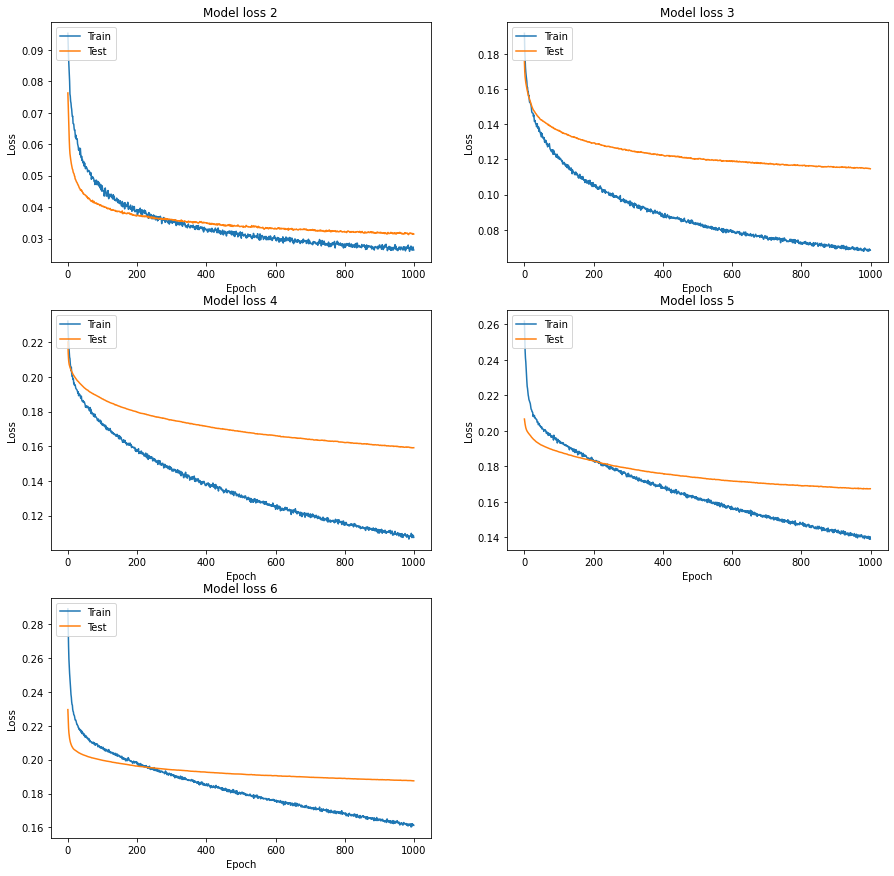

In [13]:
fig = plt.figure(figsize = (15, 15))
for i in range(5):
    fig.add_subplot(3, 2, i+1)
    plt.plot(history_ft[i+2].history['loss'])
    plt.plot(history_ft[i+2].history['val_loss'])
    plt.title('Model loss '+str(i+2))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')